# Automatic Ticket Assignment

### **Problem Statement:**

Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service.

Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

### **Objective:**

The objective of the project is :

Learn how to use different classification models.
Use transfer learning to use pre-built models.
Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.
Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.
This capstone project intends to reduce the manual intervention of IT operations or Service desk teams by automating the ticket assignment process.The goal here is to create a text classification based ML model that can automatically classify any new tickets by analysing ticket description to one of the relevant Assignment groups, which could be later integrated to any ITSM tool like Service Now. Based on the ticket description our model will output the probability of assigning it to one of the 74 Groups.

# Preparing the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.5.0'

# Loading the relevent Libraries

In [ ]:
!pip install pandas-profiling==2.7.1

In [ ]:
pip install wordcloud

In [ ]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np 
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Understand the Data

In [ ]:
path = '/content/drive/MyDrive/NLP_Project/IT-Ticket-Classification.xlsx'
raw_data = pd.read_excel(path)

In [ ]:
## Quick View 
raw_data.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [ ]:
# Having a basic look into the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [ ]:
raw_data.describe()

Short description Description             Caller Assignment group
count               8492        8499               8500             8500
unique              7481        7817               2950               74
top       password reset         the  bpctwhsn kzqsbmtp            GRP_0
freq                  38          56                810             3976

In [ ]:
report = pandas_profiling.ProfileReport(raw_data)

report

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

 ***Observation:***

#### The excel sheet contains 4 columns of ticket details which have total of 8500 rows.


1.   Short description --> Contains 8492 records, i.e there are around 8 null records.
2.   Description --> Contains 8499 records, i.e there are around 1 null records.
3.   Caller --> Doesn't have any blank data
2.   Assignment group --> Doesn't have any blank data

In [ ]:
# Shape and Columns of the data
raw_data.shape

(8500, 4)

In [ ]:
# Columns of the data
raw_data.columns

Index(['Short description', 'Description', 'Caller', 'Assignment group'], dtype='object')

In [ ]:
# Checking the Number of unique values of the Assignment Colummn
raw_data['Assignment group'].nunique()

74

In [ ]:
# Finding the null columns in the dataset

raw_data[raw_data.isna().any(axis=1)]

Short description  ... Assignment group
2604                       NaN  ...           GRP_34
3383                       NaN  ...            GRP_0
3906                       NaN  ...            GRP_0
3910                       NaN  ...            GRP_0
3915                       NaN  ...            GRP_0
3921                       NaN  ...            GRP_0
3924                       NaN  ...            GRP_0
4341                       NaN  ...            GRP_0
4395  i am locked out of skype  ...            GRP_0

[9 rows x 4 columns]

**Observation:**

* Data has 4 columns and all of them are string columns.
* There are totally 8500 rows and there seems to be some missing values in data columns, which needs to be looked into and handled.
* We have 74 unique assignment groups - GRP_0 the most frequent item with 3976 entries.
* Caller columns mainly contains user details and can be dropped as it isn't providing us with any useful inference.
* Assignment group is our target column with multiple classes. A perfect case of Multiclass Classification problem.

# Data Cleansing
We will perform the stated actions - 

* Dropping of the duplicates
* Dropping the Callers Column from Dataset
* Removal of special characters, trailing spaces, numbers
* Converting strings to lower case
* Merging small groups
* Merging both Description Columns
* Removal of null columns

In [ ]:
# Filling nulls of the dataset
raw_data.fillna(" ", inplace=True)
raw_data.shape

(8500, 4)

In [ ]:
## Duplicates of the dataset 
raw_data[raw_data.duplicated()]

Short description  ... Assignment group
51                           call for ecwtrjnq jpecxuty  ...            GRP_0
229                          call for ecwtrjnq jpecxuty  ...            GRP_0
493                     ticket update on inplant_872730  ...            GRP_0
512                                    blank call //gso  ...            GRP_0
667   job bkbackup_tool_powder_prod_full failed in j...  ...            GRP_8
...                                                 ...  ...              ...
7836             probleme mit erpgui \tmqfjard qzhgdoua  ...           GRP_24
8051               issue on pricing in distributor_tool  ...           GRP_21
8093  reset passwords for prgthyuulla ramdntythanjes...  ...           GRP_17
8347                           blank call // loud noise  ...            GRP_0
8405                           unable to launch outlook  ...            GRP_0

[83 rows x 4 columns]

In [ ]:
# Removing Duplicates
raw_data = raw_data.drop_duplicates(['Short description', 'Description', 'Caller', 'Assignment group'])

In [ ]:
# Removing the Callers column 
callers = raw_data['Caller'].unique()
raw_data.drop(columns='Caller',inplace=True)
raw_data.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 3 columns]

In [ ]:
# Define a function to clean the data
import re
import sys
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False
        
def clean_data(text):
    text = text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [ ]:
# Apply the cleaning function to entire dataset
raw_data['Description'] = raw_data['Description'].apply(clean_data)

# Verify the data
raw_data.head(10)

Short description  ... Assignment group
0                                        login issue  ...            GRP_0
1                                            outlook  ...            GRP_0
2                                 cant log in to vpn  ...            GRP_0
3                      unable to access hr_tool page  ...            GRP_0
4                                       skype error   ...            GRP_0
5     unable to log in to engineering tool and skype  ...            GRP_0
6  event: critical:HostName_221.company.com the v...  ...            GRP_1
7  ticket_no1550391- employment status - new non-...  ...            GRP_0
8               unable to disable add ins on outlook  ...            GRP_0
9                    ticket update on inplant_874773  ...            GRP_0

[10 rows x 3 columns]

In [ ]:
# Group the tickets count < 100 as GRP_A
Ticket1 = pd.DataFrame(raw_data['Assignment group'].value_counts())
Ticket1 = Ticket1.T
Ticket1

GRP_0  GRP_8  GRP_24  GRP_12  ...  GRP_67  GRP_73  GRP_64  GRP_61
Assignment group   3934    645     285     257  ...       1       1       1       1

[1 rows x 74 columns]

In [ ]:
raw_data['Count'] = raw_data.apply(lambda row: Ticket1[row['Assignment group']] , axis=1)
raw_data.loc[raw_data['Count'] <= 100 , "Assignment group"] = "GRP_A"

In [ ]:
# Merging "Short description" and "Description" column
raw_data['Description'] = raw_data['Short description'] + ' '+ raw_data['Description']
raw_data.drop(columns=['Short description','Count'],inplace=True)
raw_data.head()

Description Assignment group
0  login issue verified user details employee and...            GRP_0
1  outlook hello team my meetings skype meetings ...            GRP_0
2    cant log in to vpn hi cannot log on to vpn best            GRP_0
3  unable to access hr_tool page unable to access...            GRP_0
4                           skype error  skype error            GRP_0

**Observations :** 

* Entire dataset is converted into lower case.
* Users email addresses will add NO value to our analysis, despite the fact that user id is given in the caller column. So all email adresses are removed from the dataset
* All numerals are removed because they were dominating the dataset if we were converting them into their word representation otherwise.
* All punctuation marks are removed which used to be a hindrance in lemmatization.
* All occurances of more than one blank spaces, horizontal tab spaces, new line breaks etc. have been replaced with single blank space.

# Exploratory Data Analysis

#### Grouping by Categories

In [ ]:
## Grouping by Categories
rd_grp = raw_data.groupby(['Assignment group']).size().reset_index(name='counts')
rd_grp

Assignment group  counts
0             GRP_0    3934
1            GRP_10     140
2            GRP_12     257
3            GRP_13     145
4            GRP_14     118
5            GRP_19     215
6             GRP_2     241
7            GRP_24     285
8            GRP_25     116
9             GRP_3     200
10           GRP_33     107
11            GRP_5     128
12            GRP_6     183
13            GRP_8     645
14            GRP_9     252
15            GRP_A    1451

In [ ]:
rd_grp.describe()

counts
count    16.000000
mean    526.062500
std     967.964357
min     107.000000
25%     137.000000
50%     207.500000
75%     264.000000
max    3934.000000

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8417 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8417 non-null   object
 1   Assignment group  8417 non-null   object
dtypes: object(2)
memory usage: 197.3+ KB


### Distribution by group

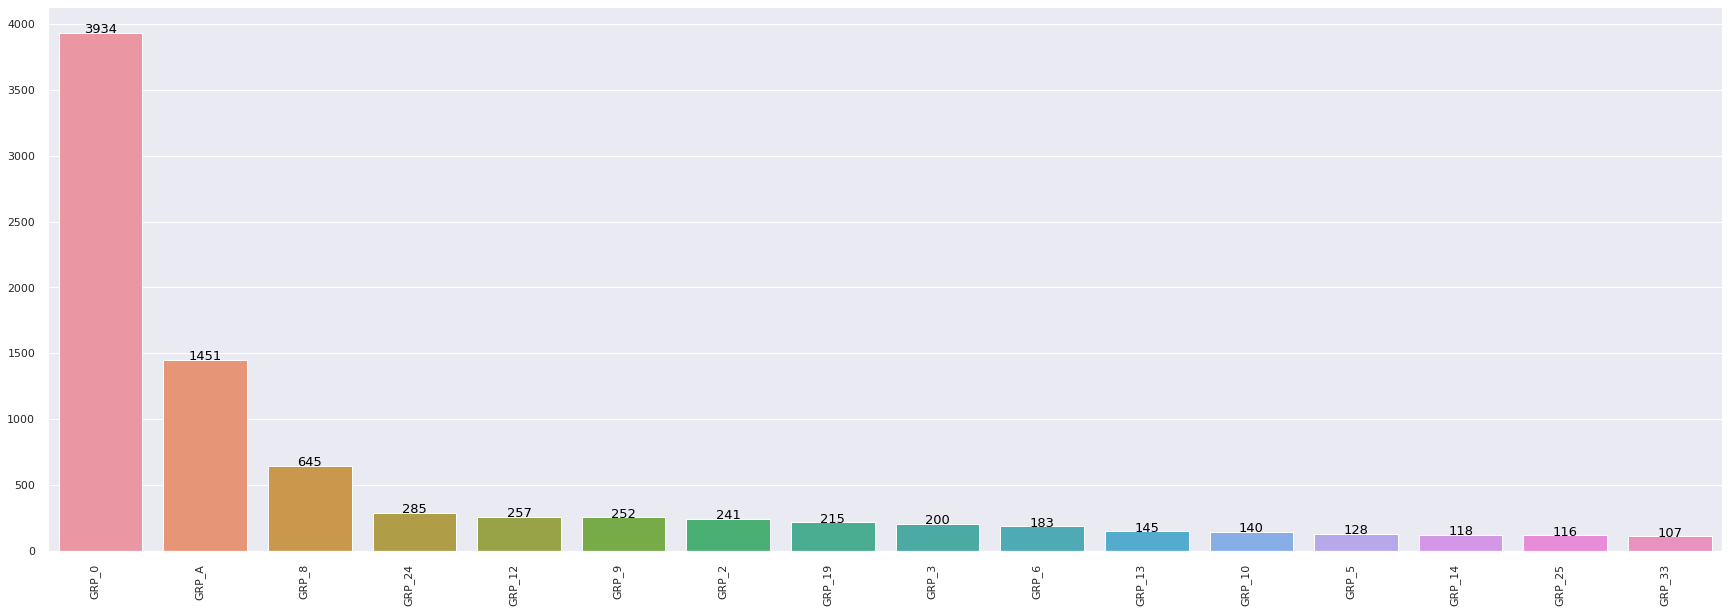

In [ ]:
sns.set_theme();
 
assgn = raw_data['Assignment group'].value_counts()
plt.figure(figsize=(30,10))
 
cntplot = sns.barplot(x=assgn.index,y=assgn.values)
cntplot.set_xticklabels(cntplot.get_xticklabels(), rotation=90, ha="right")
for i in range(len(assgn)):
  cntplot.text(i, assgn.values[i], assgn.values[i], color='black', ha='center', fontsize=13)
plt.show()

**Observation:**

* The Target class distrubtion is extremely right skewed.
* GRP_0 has max occurences (amounting to 3926) which makes for almost ~50% of the data.
* The merged entries GRP_A has around 1450 occurences.
* GRP_0, GRP_A and GRP_8 together makes to around 70% of the available data.  

### Description length analysis and its relation with Assignment group

In [ ]:
raw_data['desc_len'] = raw_data['Description'].str.len()

Text(0.5, 1.0, 'Distribution of length of descriptions')

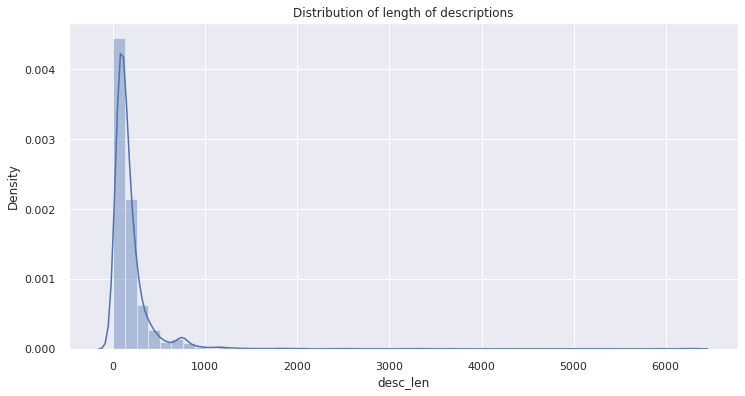

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(raw_data['desc_len']).set_title('Distribution of length of descriptions')

**Observation:**

The distribution of description lengths is extremely skewed, let us try to omit the tail and focus the major portion from the right skewed graph.

In [ ]:
raw_data['desc_len'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count    8417.000000
mean      190.084828
std       319.030581
min         3.000000
25%        74.000000
50%       114.000000
75%       202.000000
90%       360.000000
95%       580.000000
max      6300.000000
Name: desc_len, dtype: float64

In [ ]:
len(raw_data[raw_data['desc_len'] > 1100])

92

**Observation:**

* Half of the records have less than 120 words.
* 90% of descriptions have less than 620 words.
* The remaining 10% records are very long and extremely skewed in comparison with the remaining portion.

Let us consider till the 95th percentile for further visualization.

Text(0.5, 1.0, 'Distribution of length of descriptions')

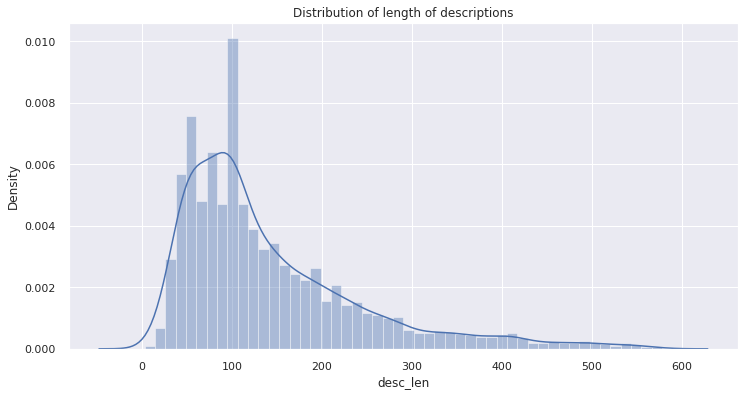

In [ ]:
raw_data_95 = raw_data[raw_data['desc_len'] < raw_data['desc_len'].quantile(0.95)]
plt.figure(figsize=(12,6))
sns.distplot(raw_data_95['desc_len']).set_title('Distribution of length of descriptions')

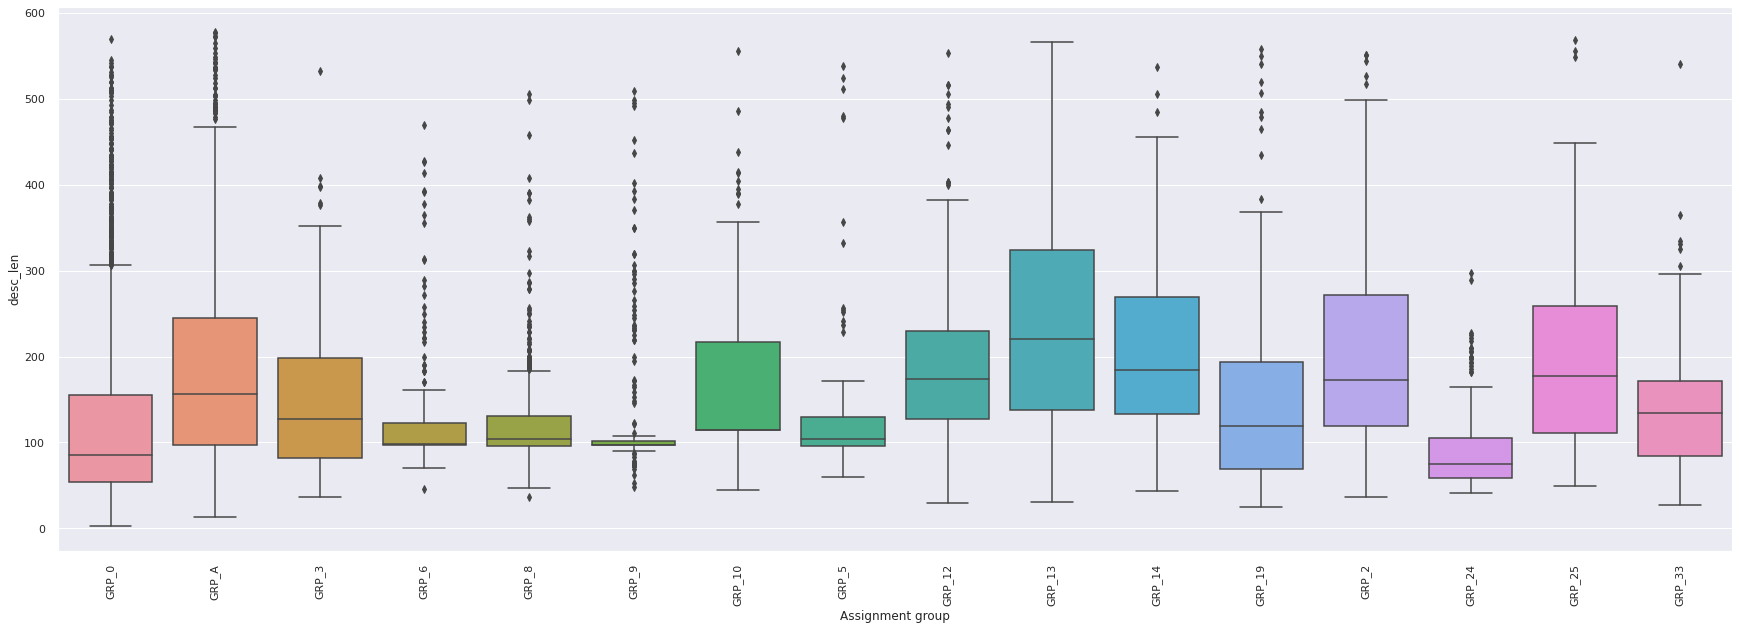

In [ ]:
plt.figure(figsize=(30,10))
lengths = sns.boxplot(data=raw_data_95, x='Assignment group', y='desc_len')
lengths.set_xticklabels(lengths.get_xticklabels(),rotation=90)
plt.show()

**Observation:**

There is no clear pattern visible to describe the relation between group and description lengths. 

It is however visible that groups have outliers and some groups fall in the lower range while most of them have lengths in the range of 100 to 400.

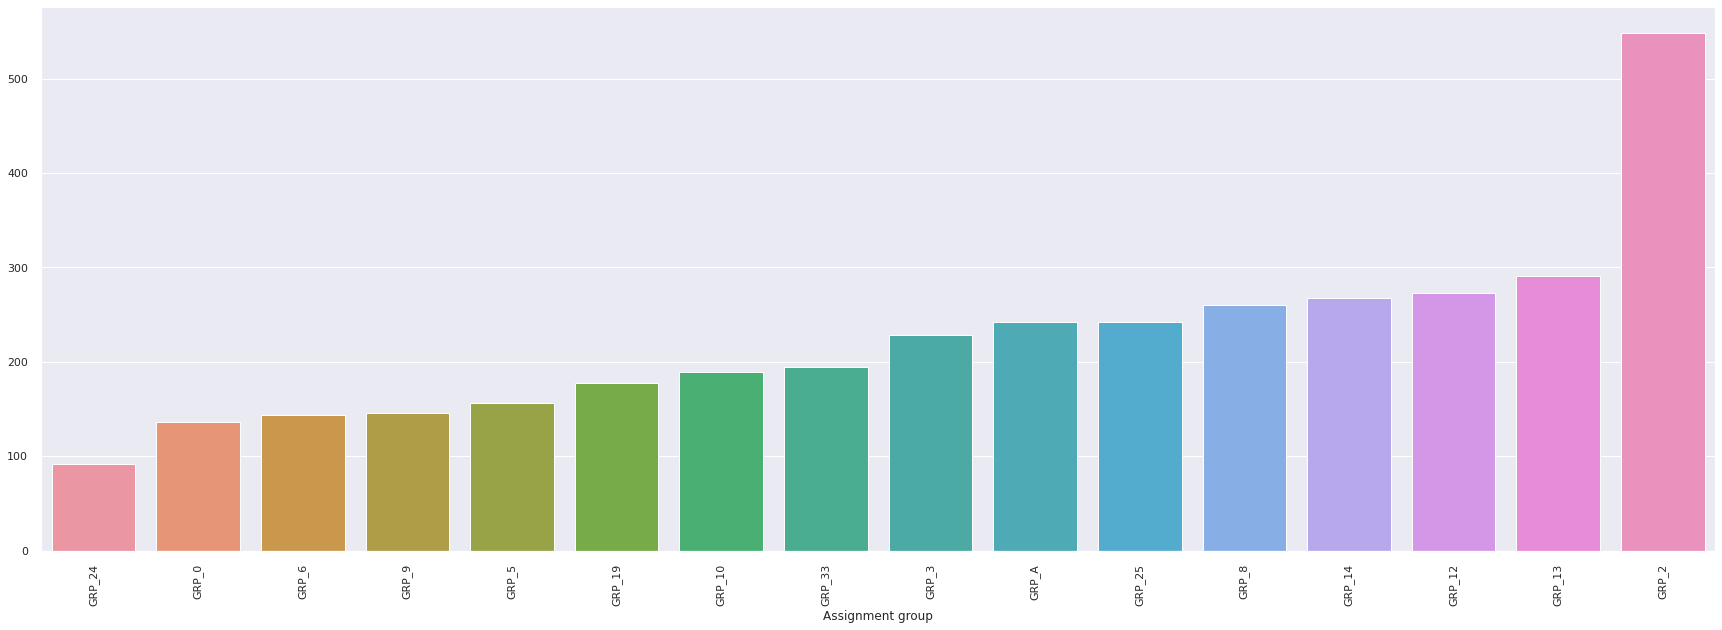

In [ ]:
plt.figure(figsize=(30,10))

plot_meandesc_len=sns.barplot(x=raw_data.groupby(['Assignment group']).mean()['desc_len'].sort_values().index,
                               y=raw_data.groupby(['Assignment group']).mean()['desc_len'].sort_values().values)
plot_meandesc_len.set_xticklabels(plot_meandesc_len.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
raw_data.drop(columns=['desc_len'],inplace=True)
raw_data.head(10)

Description Assignment group
0  login issue verified user details employee and...            GRP_0
1  outlook hello team my meetings skype meetings ...            GRP_0
2    cant log in to vpn hi cannot log on to vpn best            GRP_0
3  unable to access hr_tool page unable to access...            GRP_0
4                           skype error  skype error            GRP_0
5  unable to log in to engineering tool and skype...            GRP_0
6  event: critical:HostName_221.company.com the v...            GRP_A
7  ticket_no1550391- employment status - new non-...            GRP_0
8  unable to disable add ins on outlook unable to...            GRP_0
9  ticket update on inplant_874773 ticket update ...            GRP_0

**Observation:**

There is a clear that the data of GRP_2 has very long description data. Other group records have mean length lesser than 500 words.

# Text Pre-processing

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. In grammar, inflection is known as the modification of a word to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, and mood. An inflection expresses one or more grammatical categories with a prefix, suffix or infix, or another internal modification such as a vowel change.

**Stemming**

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

**Lemmatization**

Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization, root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

raw_data['Description'] = raw_data['Description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#Verify the data
raw_data.head()

Description Assignment group
0  login issue verify user detail employee and ma...            GRP_0
1  outlook hello team meeting skype meeting etc b...            GRP_0
2  can not log in to vpn hi can not log on to vpn...            GRP_0
3  unable to access hr_tool page unable to access...            GRP_0
4                          skype error   skype error            GRP_0

In [ ]:
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi', 'etc'
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

**Top Unigrams**

In [ ]:
# Top Unigrams after removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams_sw = get_top_n_ngrams(raw_data.Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(uni_grams_sw, columns = ['Summary' , 'count'])
figure = df.groupby('Summary').sum()['count'].sort_values(ascending=False)
figure.head(10)

Summary
job         3490
password    2344
erp         2077
fail        1748
user        1690
company     1585
issue       1526
reset       1522
unable      1496
access      1452
Name: count, dtype: int64

In [ ]:
# Top Bigrams after removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams_sw = get_top_n_ngrams(raw_data.Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(bi_grams_sw, columns = ['Summary' , 'count'])
figure = df.groupby('Summary').sum()['count'].sort_values(ascending=False)
figure.head(10)

Summary
job scheduler         949
fail job              789
password reset        786
fail job_scheduler    785
00 job                761
job job               617
job fail              472
account lock          461
backup circuit        441
reset password        388
Name: count, dtype: int64

In [ ]:
# Top Trigrams after removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams_sw = get_top_n_ngrams(raw_data.Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(tri_grams_sw, columns = ['Summary' , 'count'])
figure = df.groupby('Summary').sum()['count'].sort_values(ascending=False)
figure.head(10)

Summary
fail job scheduler       789
job fail job             461
job job fail             460
00 job job               450
fail job_scheduler 09    308
fail job_scheduler 10    285
group acl inside         185
src inside dst           185
access group acl         185
fail job_scheduler 08    171
Name: count, dtype: int64

## **Word Cloud**
A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

Also known as tag clouds or text clouds, these are ideal ways to pull out the most pertinent parts of textual data, often also help business users compare and contrast two different pieces of text to find the wording similarities between the two.

Let's write a generic method to generate Word Clouds

In [ ]:
from wordcloud import WordCloud
def generate_word_clod(corpus,x):
    wordcloud = WordCloud(width = 500, height = 500, 
                    background_color ='black', 
                    stopwords=STOP_WORDS,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off")
    plt.title("Most common words of {}".format(x)) 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
value = raw_data['Assignment group'].value_counts().sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_A', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2',
       'GRP_19', 'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14',
       'GRP_25', 'GRP_33'],
      dtype='object')

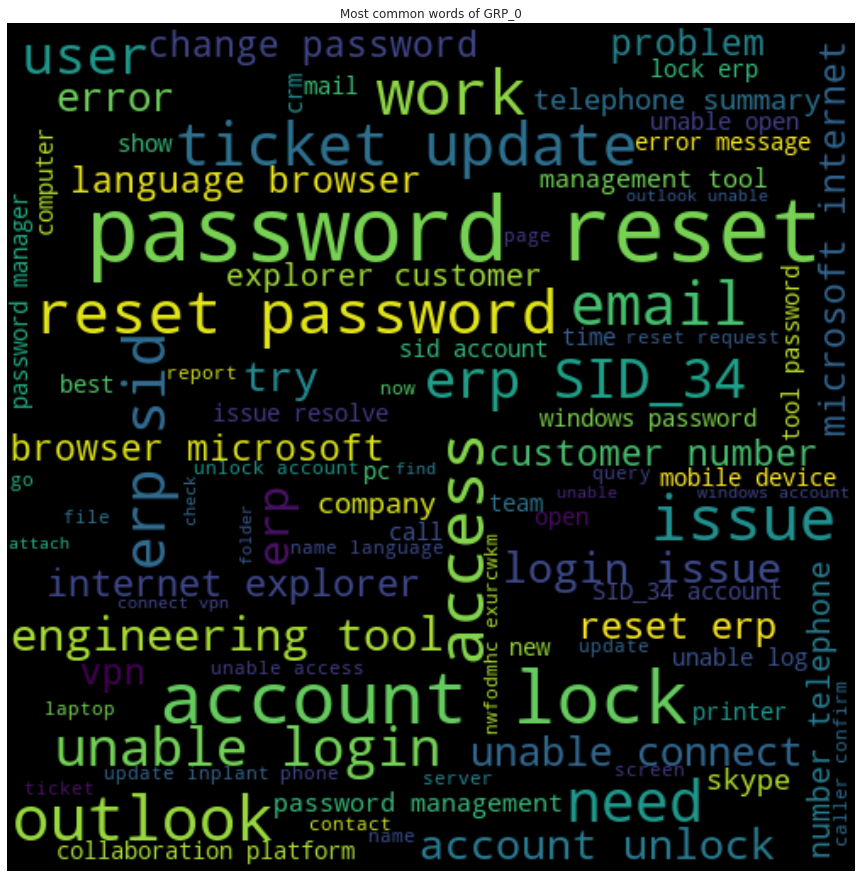

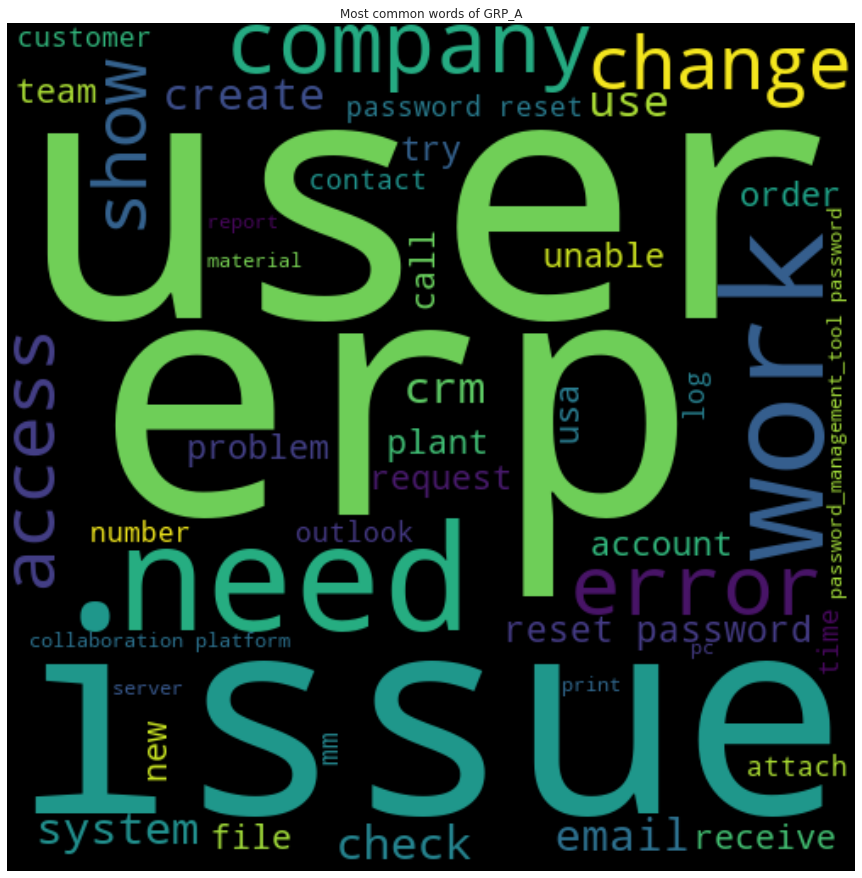

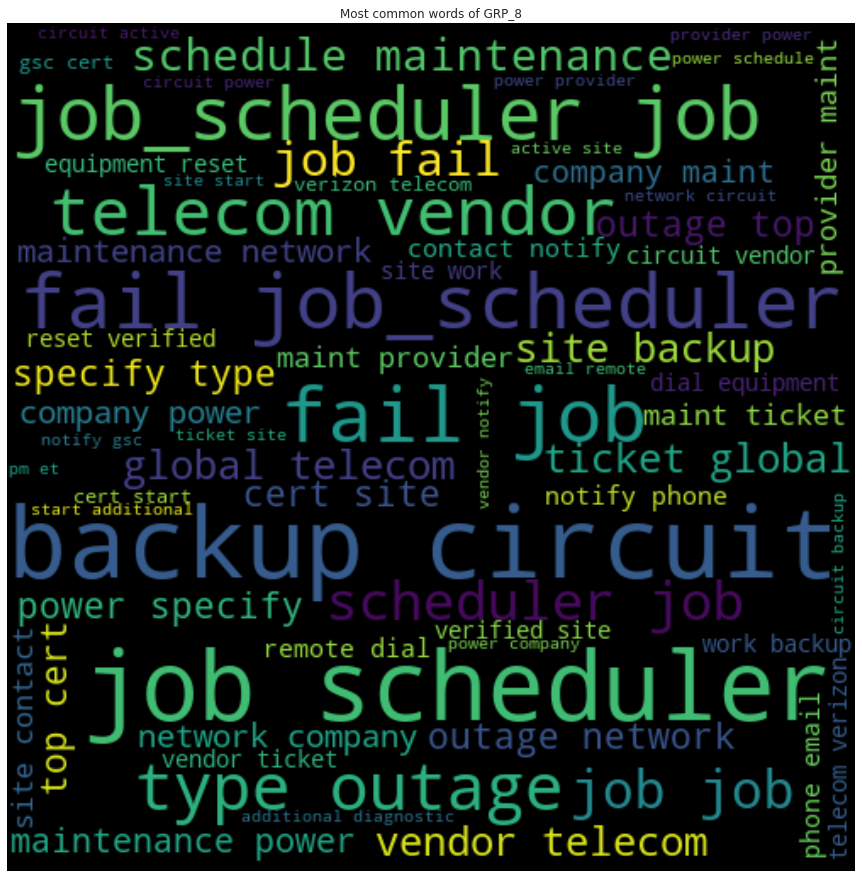

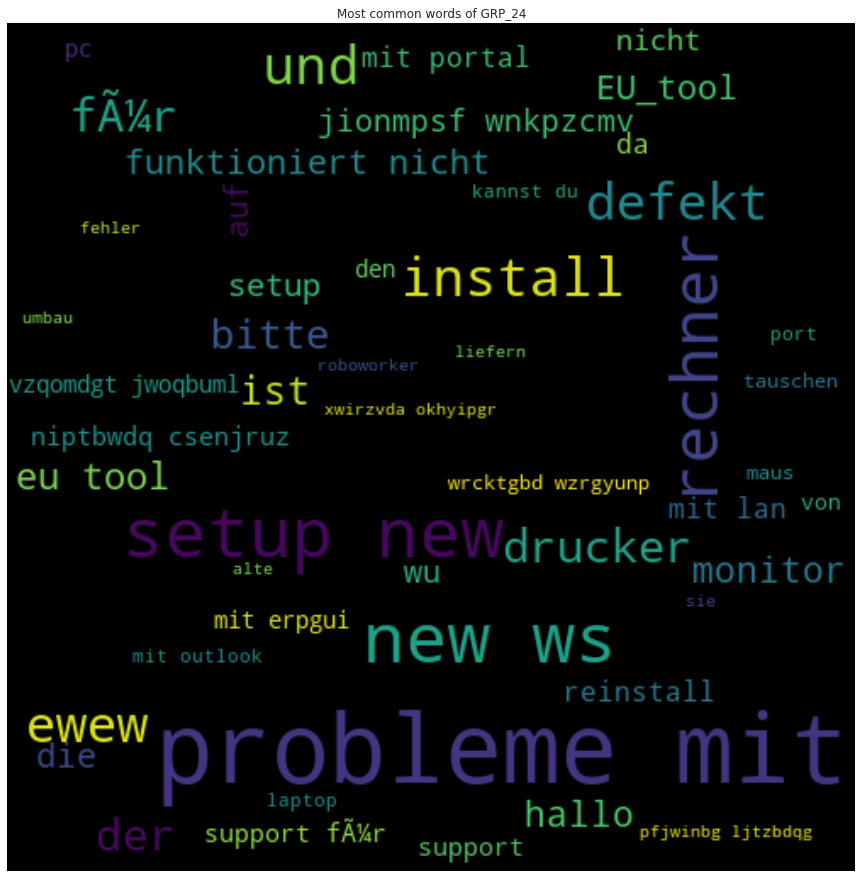

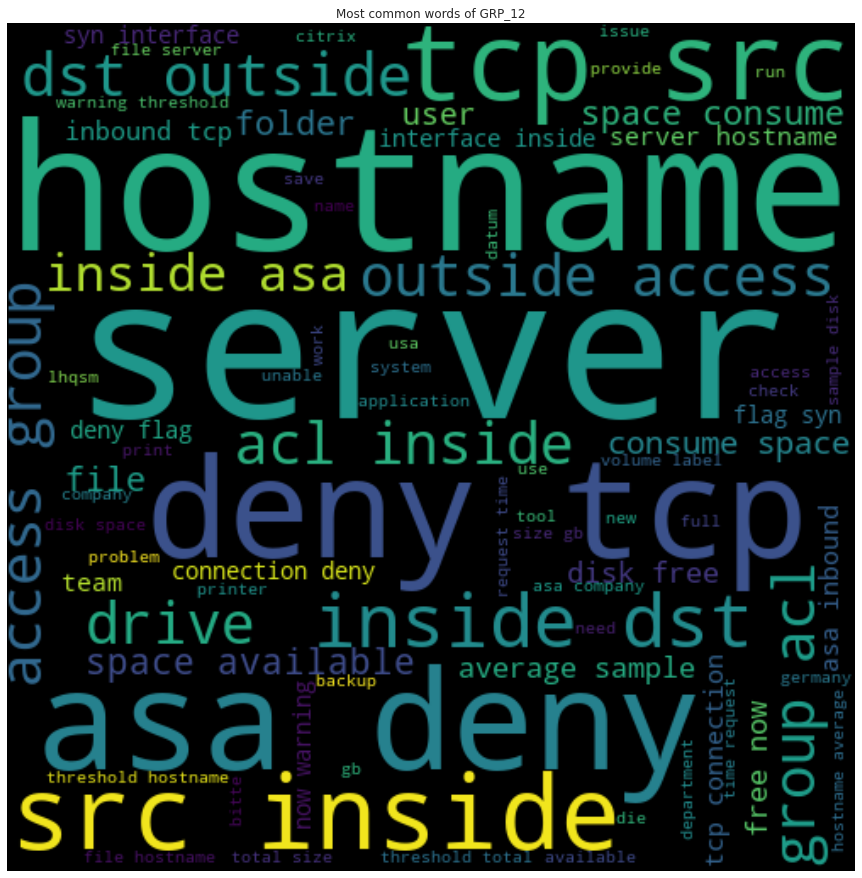

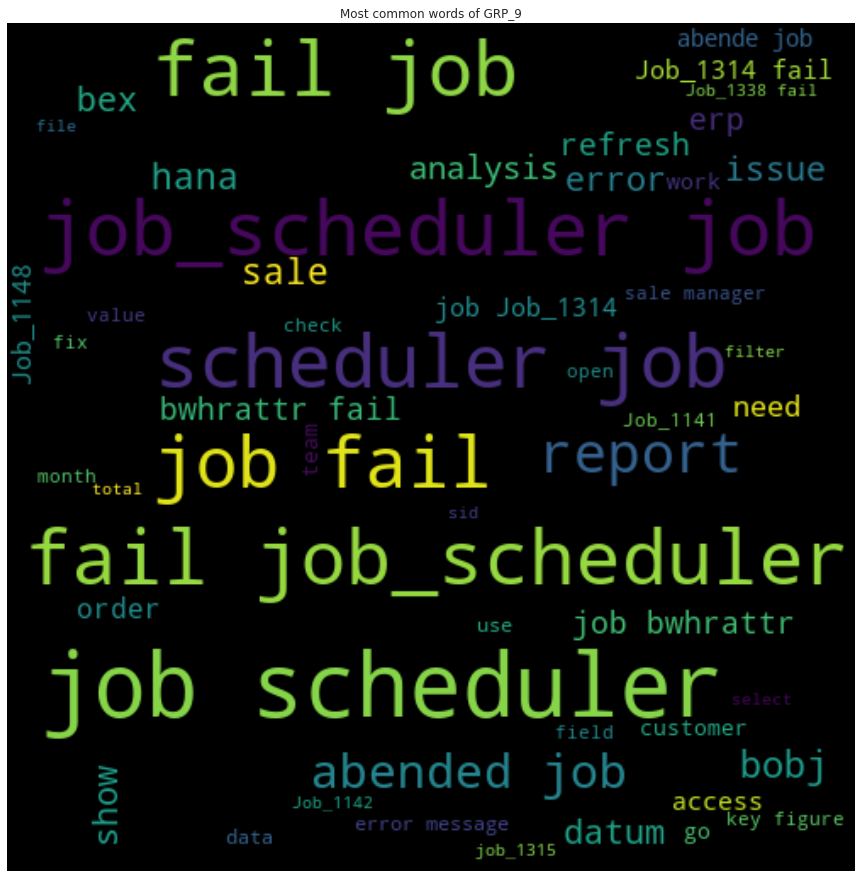

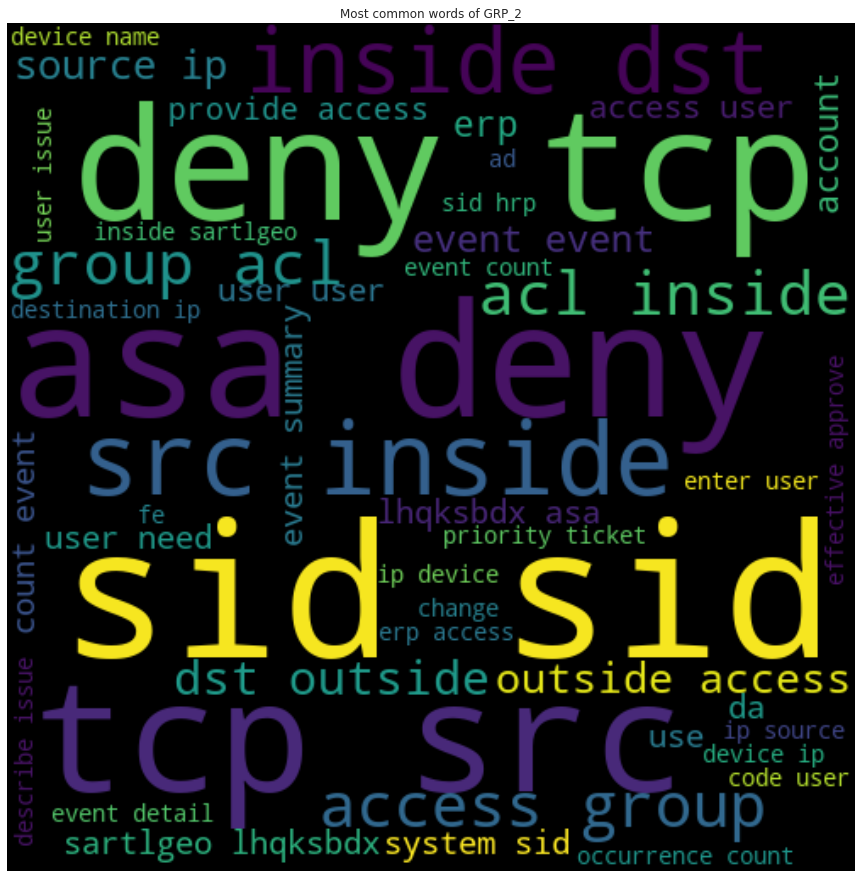

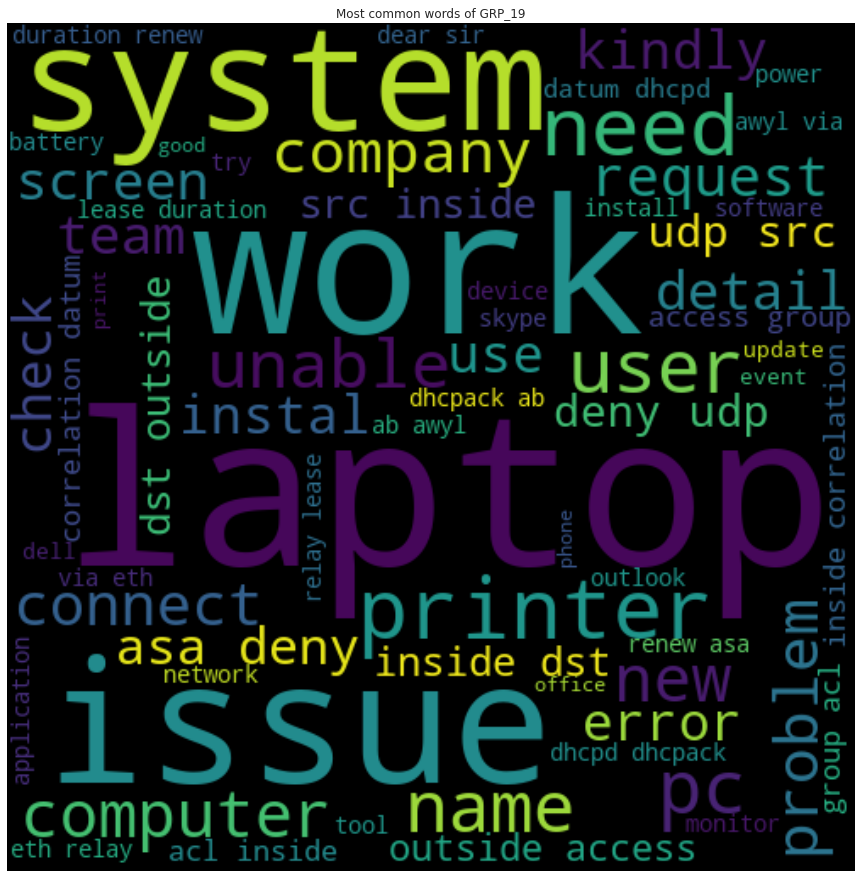

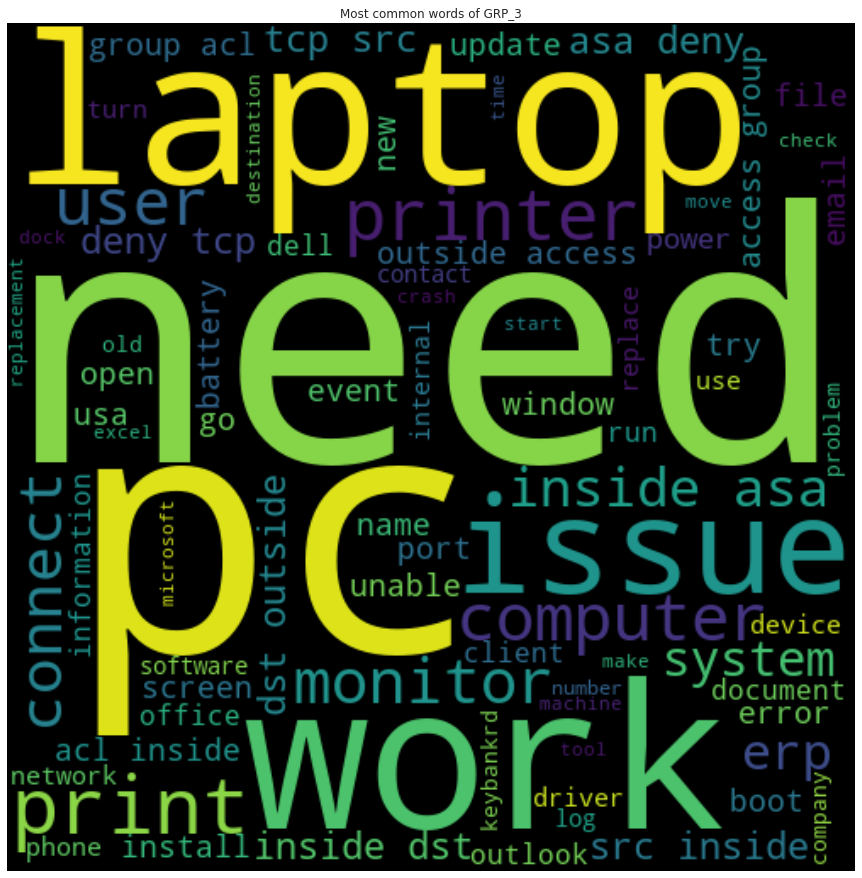

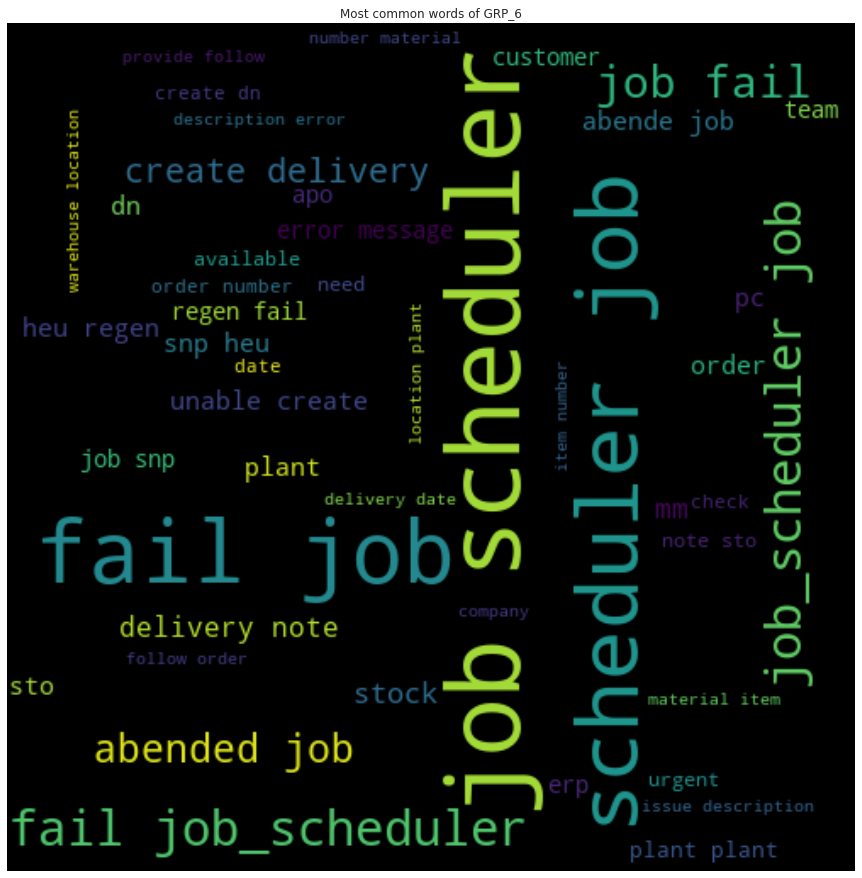

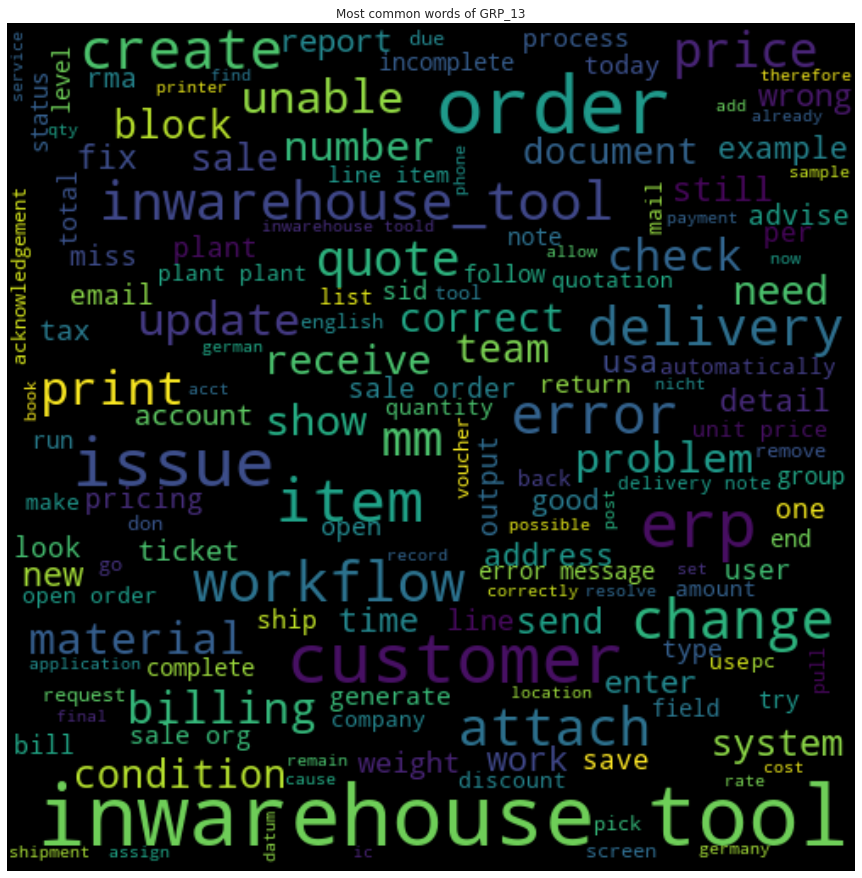

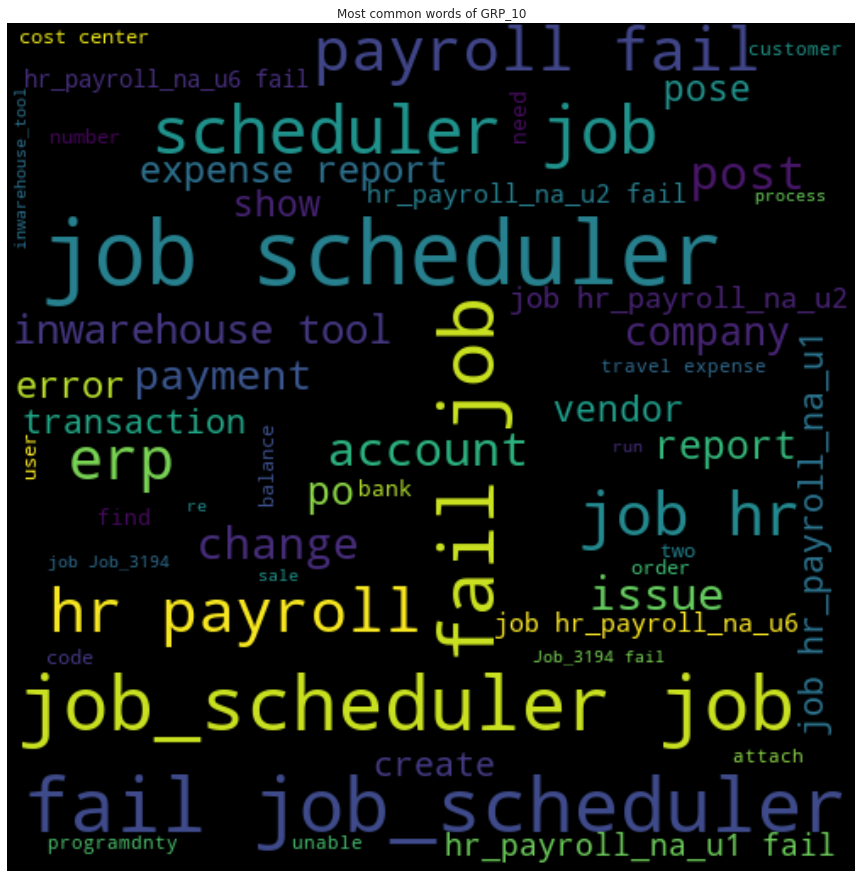

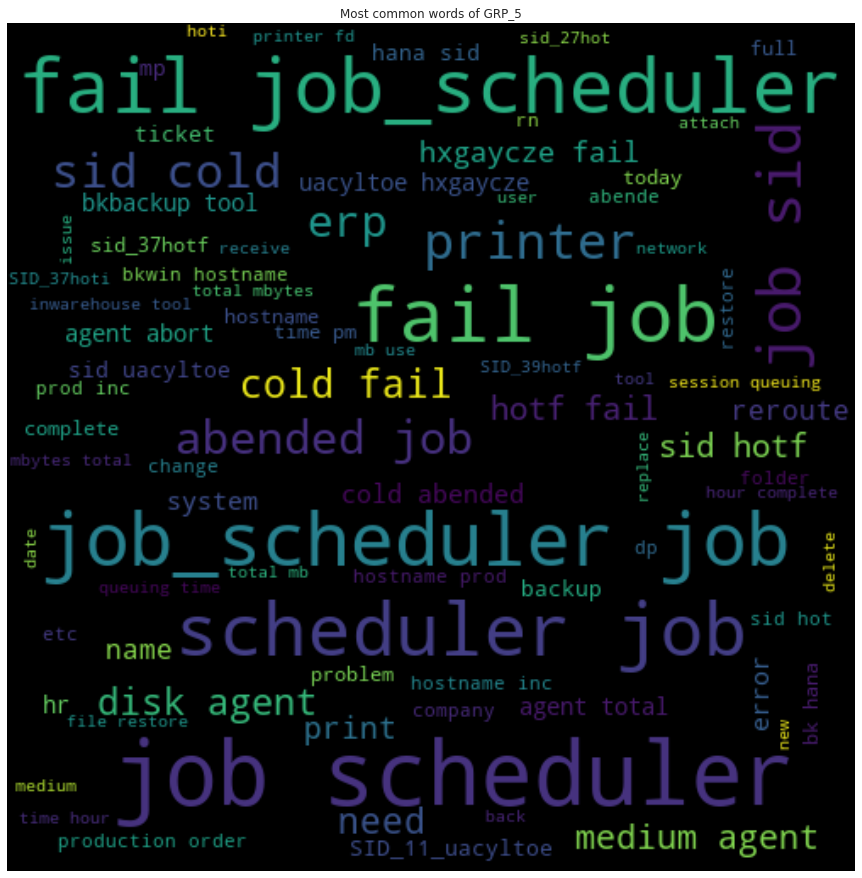

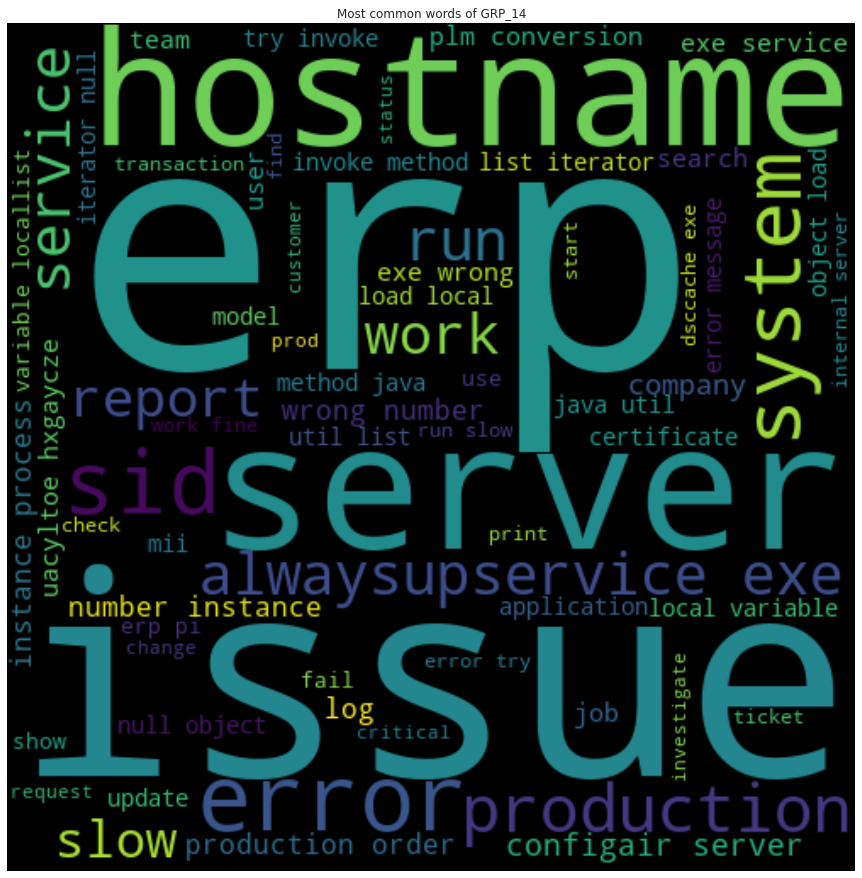

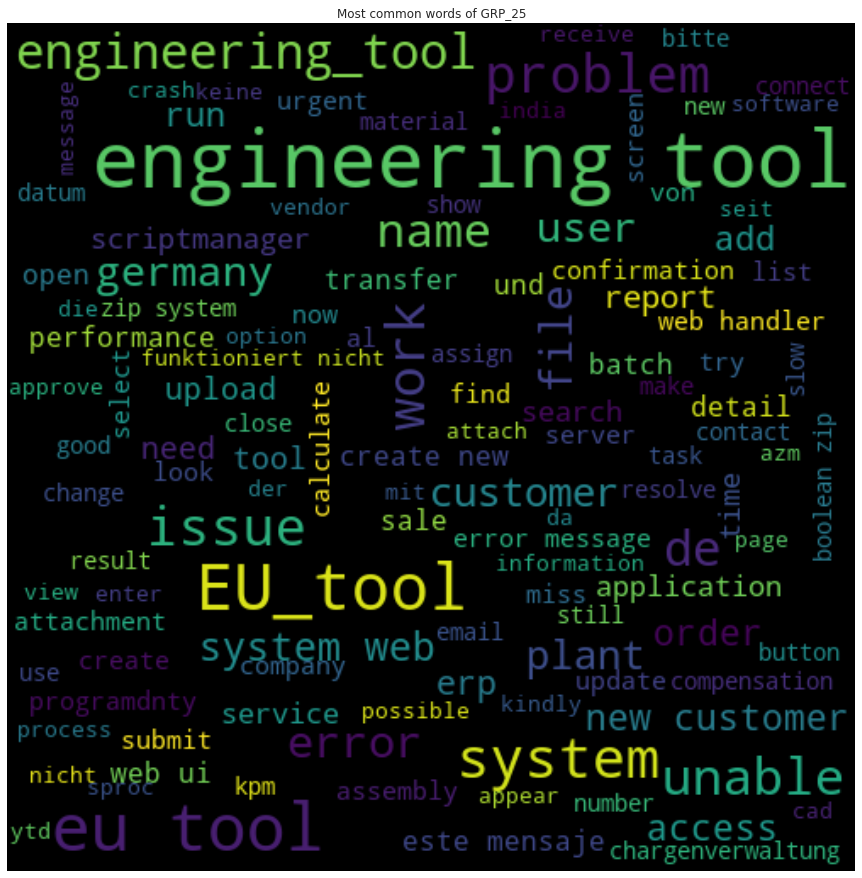

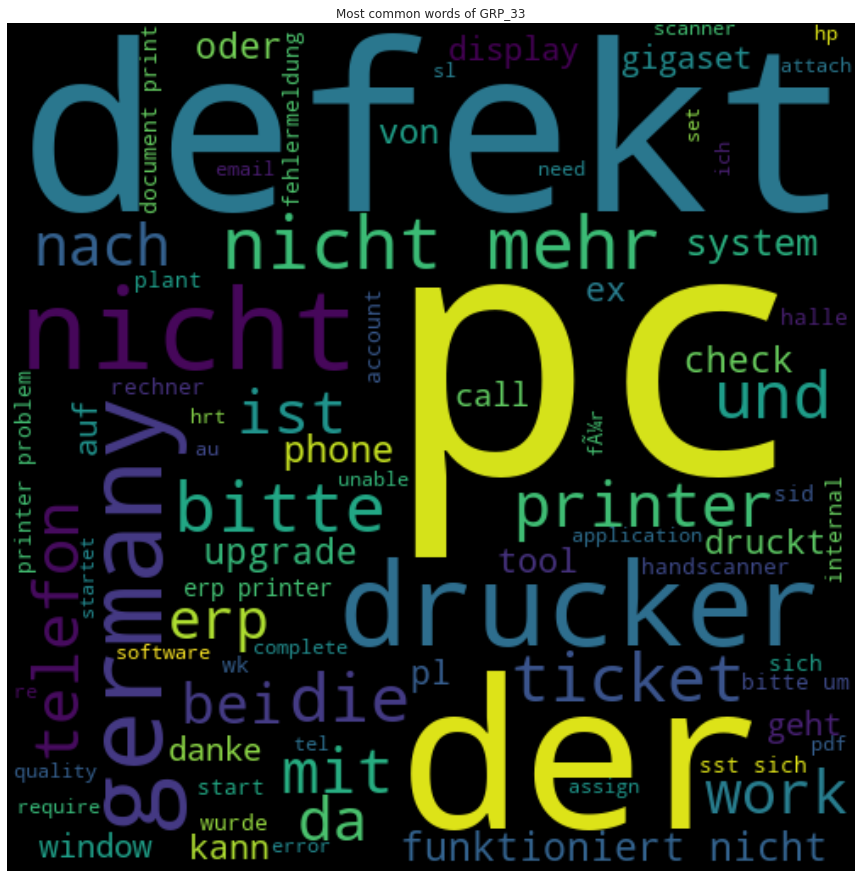

In [ ]:
for i in range(16):
    generate_word_clod(' '.join(raw_data[raw_data['Assignment group'] == value[i]].Description.str.strip()),value[i])

 **Comments:**


It's indicative from the n-gram analysis and the word cloud is that the entire dataset speaks more about issues around

*   password reset
*   fail job & scheduler

Analysis on GRP_0 which is the most frequent group to assign a ticket to reveals that this group deals with mostly the maintenance problems such as password reset, account lock, login issue, ticket update etc.

Maximum of the tickets from GRP_0 can be reduced by self correcting itself by putting automation scripts/mechanisms to help resolve these common maintenance issues. This will help in lowering the inflow of service tickets thereby saving the person/hour efforts spend and increasing the business revenue.

In [ ]:
#Export the data frame to a .csv file
raw_data.to_csv (r'/content/drive/My Drive/NLP_Project/cleaned_data.csv', index = False, header=True)

# Building the Models

We will proceed towards trying different models alogrithms mentioned below so as to classify the problem and validate the best modeling technique:

*   Multinomial Naive Bayes
*   K Nearest neighbor (KNN)
*   Support Vector Machine
*   Decision Tree
*   Random Forest

Now we'll create another column of categorical datatype from Assignment groups. Also we'll be writing some generic methods to plot evaluation metrics.

In [ ]:
# Create a target categorical column
raw_data['Target'] = raw_data['Assignment group'].astype('category').cat.codes
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8417 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8417 non-null   object
 1   Assignment group  8417 non-null   object
 2   Target            8417 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 205.5+ KB


In [ ]:
import warnings
# Traditional Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Tools & Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [ ]:
# Make a copy of the raw_data dataframe for future use
data = raw_data.copy()

# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(data.Description, 
                                                    data.Target, 
                                                    test_size=0.20, 
                                                    random_state=42)
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (6733,) (1684,)
Shape of the test set: (6733,) (1684,)


In [ ]:
# A method to train and test the model
def run_classification(Prediction_model, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    clf = Prediction_model

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', Prediction_model),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1)
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Prediction Model:', Prediction_model)
    print('-'*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('-'*80)
    #print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,value,value)
    plt.figure(figsize=(20,10))  
    sns.heatmap(cm_df, annot=True)
    print('-'*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))

### Naive Bayes

Prediction Model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
--------------------------------------------------------------------------------
Training accuracy: 61.18%
Testing accuracy: 57.36%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73       783
           1       0.00      0.00      0.00        31
           2       1.00      0.05      0.09        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00        56
           7       0.97      0.46      0.62        61
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        37
          

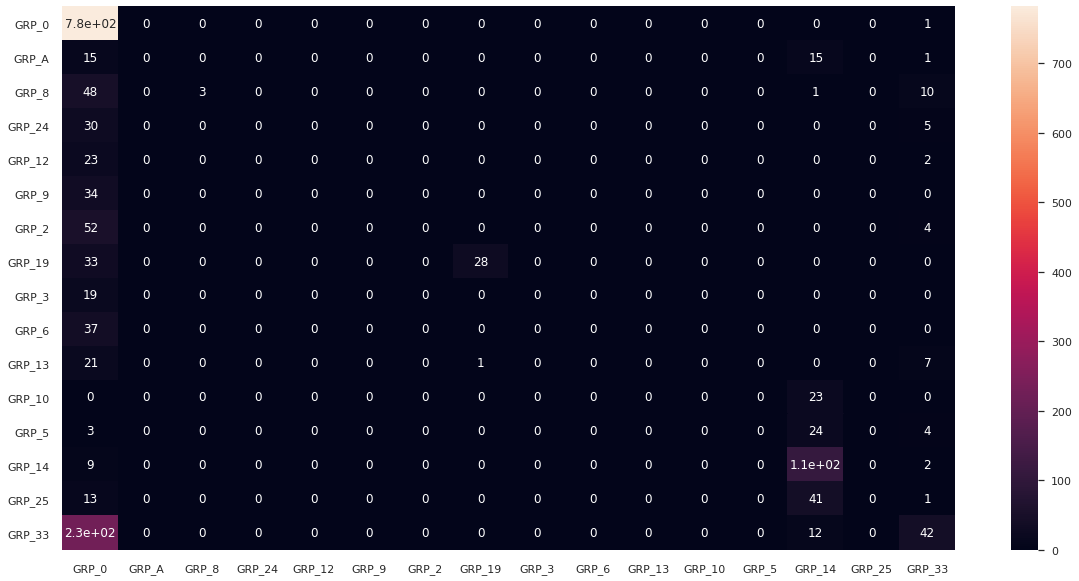

In [ ]:
run_classification(MultinomialNB(), X_train, X_test, y_train, y_test)

### K-Nearest Neighbor (KNN)

Prediction Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
--------------------------------------------------------------------------------
Training accuracy: 76.33%
Testing accuracy: 68.76%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.96      0.81       783
           1       0.67      0.58      0.62        31
           2       0.61      0.50      0.55        62
           3       0.57      0.34      0.43        35
           4       0.69      0.36      0.47        25
           5       0.45      0.26      0.33        34
           6       0.84      0.38      0.52        56
           7       0.84      0.80      0.82 

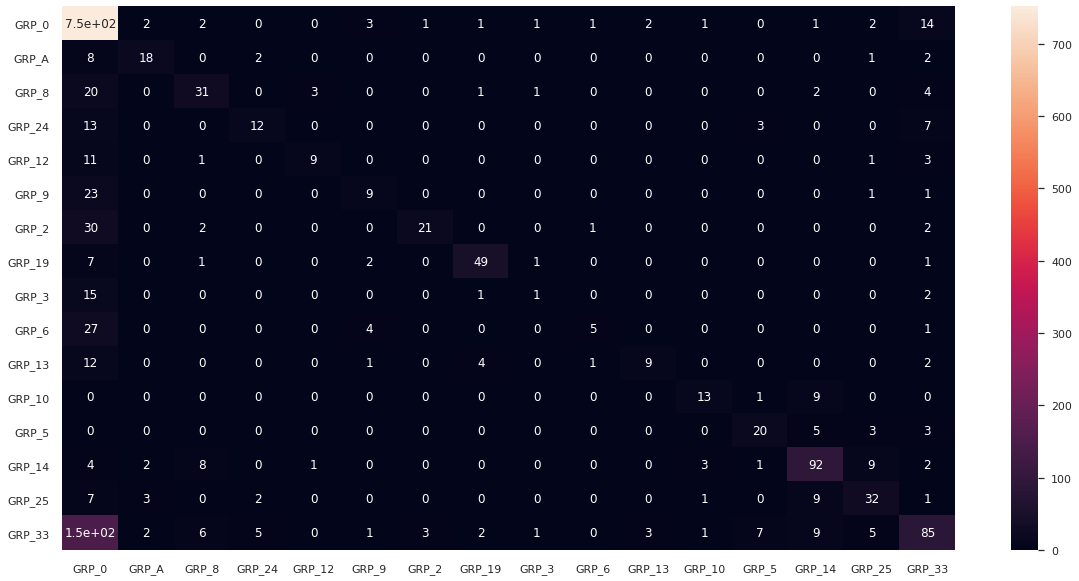

In [ ]:
run_classification(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

### Support Vector Machine (SVM)

Prediction Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
--------------------------------------------------------------------------------
Training accuracy: 95.78%
Testing accuracy: 73.22%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       783
           1       0.88      0.68      0.76        31
           2       0.75      0.61      0.67        62
           3       0.76      0.46      0.57        35
           4       0.77      0.40      0.53        25
           5       0.29      0.12      0.17        34
           6       0.77      0.41      0.53        56
 

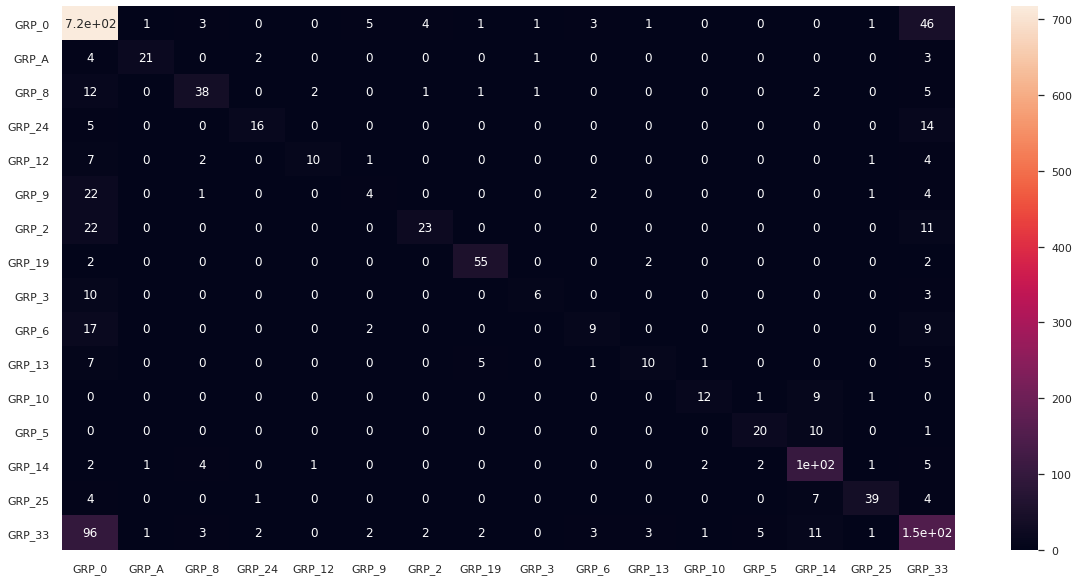

In [ ]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_train, X_test, y_train, y_test)

### Decision Trees

Prediction Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
--------------------------------------------------------------------------------
Training accuracy: 99.69%
Testing accuracy: 61.05%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78       783
           1       0.71      0.48      0.58        31
           2       0.39      0.35      0.37        62
           3       0

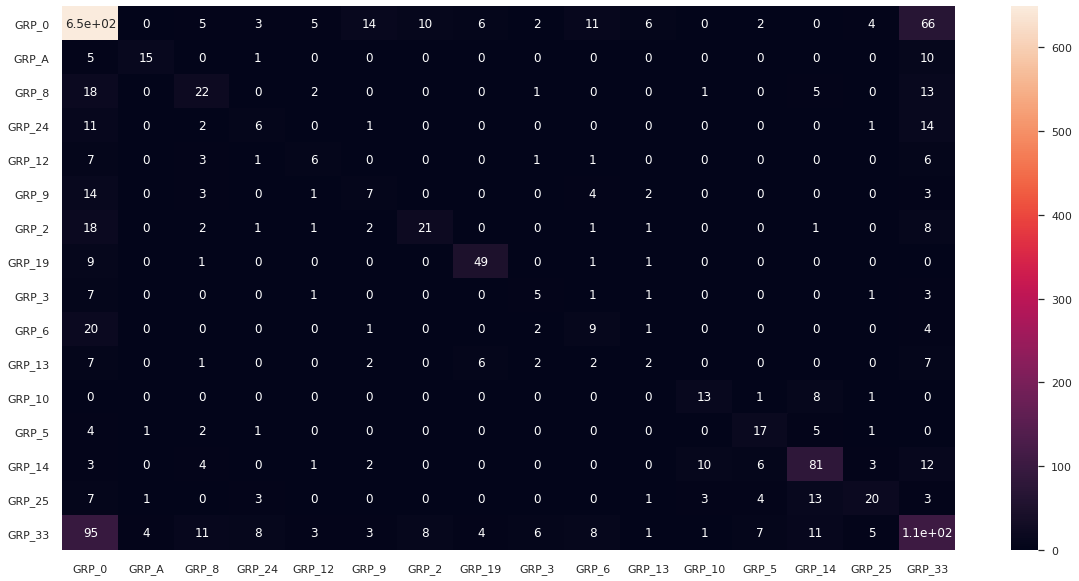

In [ ]:
run_classification(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

## **Random Forest Classifier**

Prediction Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
--------------------------------------------------------------------------------
Training accuracy: 99.69%
Testing accuracy: 67.87%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.98      0.79       783
        

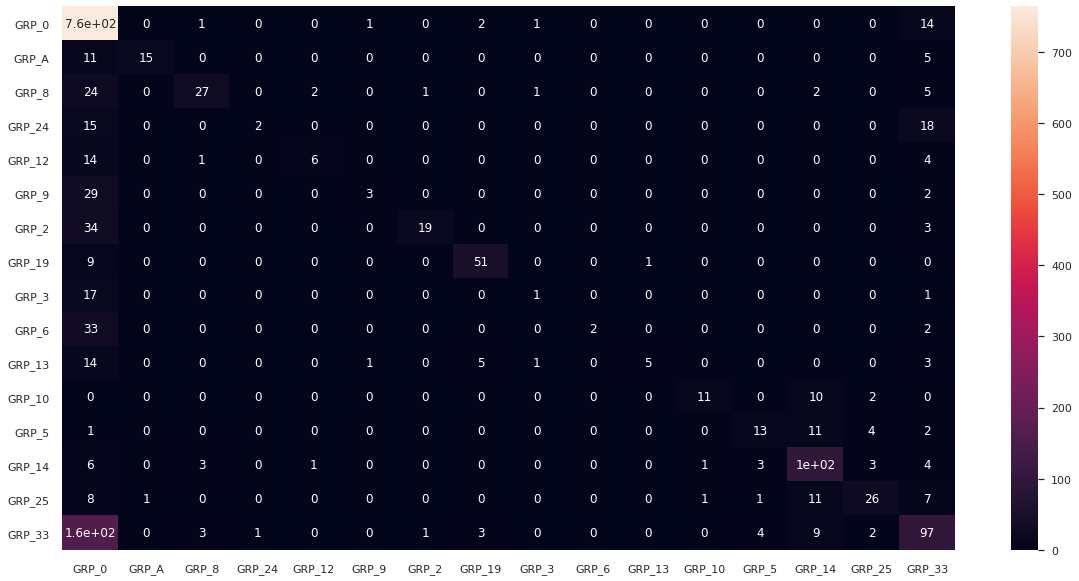

In [ ]:
from sklearn.ensemble import RandomForestClassifier
run_classification(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

### Bidirectional LSTM

In [ ]:
#Export the data frame to a .csv file
raw_data.to_csv (r'//content/drive/MyDrive/NLP_Project/temp.csv', index = False, header=True)

In [ ]:
import csv

vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8


articles = []
labels = []

with open("/content/drive/My Drive/NLP_Project/temp.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        article = row[0]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)


train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(17, activation='softmax')
])
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 17)                1105      
Total params: 395,409
Trainable params: 395,409
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
53/53 [==============================] - 31s 514ms/step - loss: 2.0282 - accuracy: 0.4678 - val_loss: 1.6565 - val_accuracy: 0.4994
Epoch 2/10
53/53 [==============================] - 26s 498ms/step - loss: 1.4446 - accuracy: 0.5908 - val_loss: 1.4409 - val_accuracy: 0.5594
Epoch 3/10
53/53 [==============================] - 27s 502ms/step - loss: 1.2425 - accuracy: 0.6346 - val_loss: 1.3894 - val_accuracy: 0.5772
Epoch 4/10
53/53 [==============================] - 26s 497ms/step - loss: 1.0952 - accuracy: 0.6759 - val_loss: 1.3195 - val_accuracy: 0.5855
Epoch 5/10
53/53 [==============================] - 27s 507ms/step - loss: 0.9374 - accuracy: 0.7096 - val_loss: 1.3017 - val_accuracy: 0.5968
Epoch 6/10
53/53 [==============================] - 27s 504ms/step - loss: 0.8213 - accuracy: 0.7488 - val_loss: 1.3126 - val_accuracy: 0.6004
Epoch 7/10
53/53 [==============================] - 27s 501ms/step - loss: 0.7122 - accuracy: 0.7832 - val_loss: 1.3547 - val_accuracy: 0.6229

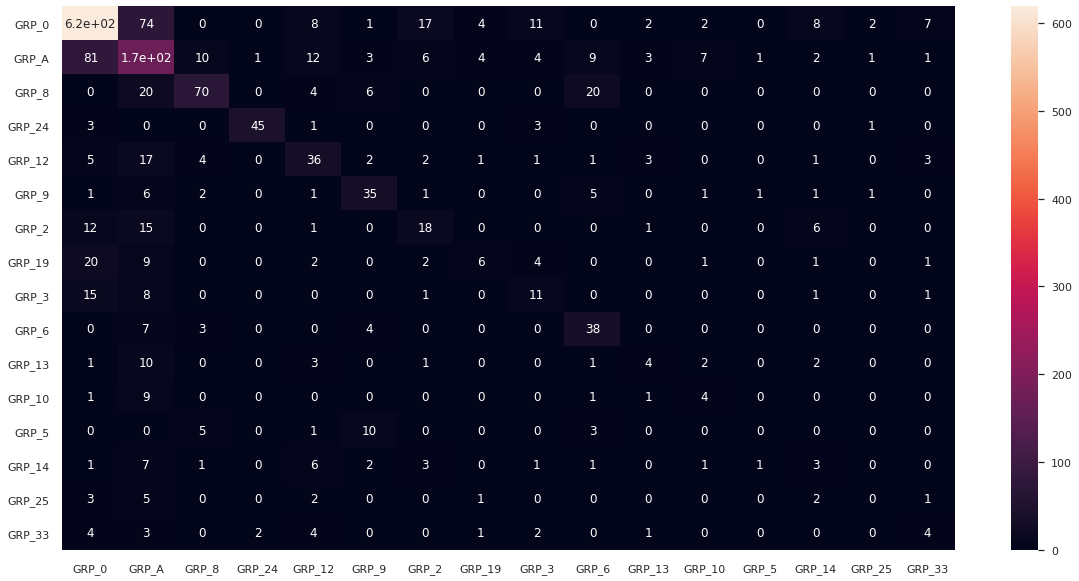

In [ ]:
run_classification(model, train_padded, validation_padded, training_label_seq, validation_label_seq,arch_name=None,pipelineRequired=False, isDeepModel=True)

Observation:

All the above models listed below are higly overfitted as the training accuracy is on higher side and testing accuracy is on lower side :-

- Multinomial - Training - 61%     : Testing - 59%
- KNN         - Training - 76%     : Testing - 69%
- Linear SVM  - Training - 96%     : Testing - 73%
- Decision Tree  - Training - 99%     : Testing - 60%
- Random forest  - Training - 99%     : Testing - 68%
- Bidirectional LSTM  - Training - 90%     : Testing - 63%




# Summary - Initial Report

Amongst all the model architectures we've tried, the accuracy of each of the model is as follows in the table. Statistical models are overfitted to a higher degree. One obvious reason is the dataset is highly imbalanced. 

Following are some of the techniques we'll be trying in Milestone-2 as part of fine tuning.

*   Dealing with imbalanced dataset.

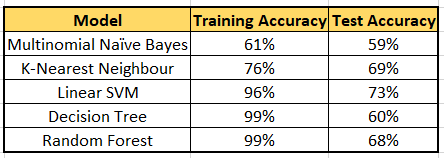

# Milestone 2 - Fine tune

## Dealing with Imbalanced dataset - Approach 1 - Split the data into Training, Validation and Test data sets


In [ ]:
data2 = data
data3 = data

data2.head()

Description Assignment group  Target
0  login issue verify user detail employee and ma...            GRP_0       0
1  outlook hello team meeting skype meeting etc b...            GRP_0       0
2  can not log in to vpn hi can not log on to vpn...            GRP_0       0
3  unable to access hr_tool page unable to access...            GRP_0       0
4                          skype error   skype error            GRP_0       0

In [ ]:
# Split the data into Training, Validation and Test data sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(data2.Description, data2.Target, test_size=0.2, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

print('\033[1mShape of the training set:\033[0m', X_train1.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', X_test1.shape, y_test.shape)
print('\033[1mShape of the validation set:\033[0m', X_val.shape, y_test.shape)

Shape of the training set: (5049,) (1684,)
Shape of the test set: (1684,) (1684,)
Shape of the validation set: (1684,) (1684,)


### Modeling with Dataset split into Training, Validation and Test data sets

#### Multinomial Naive Bayes

Prediction Model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
--------------------------------------------------------------------------------
Training accuracy: 60.61%
Testing accuracy: 57.66%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74       796
           1       0.00      0.00      0.00        24
           2       0.67      0.05      0.09        44
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00        56
           7       1.00      0.37      0.54        57
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        46
          

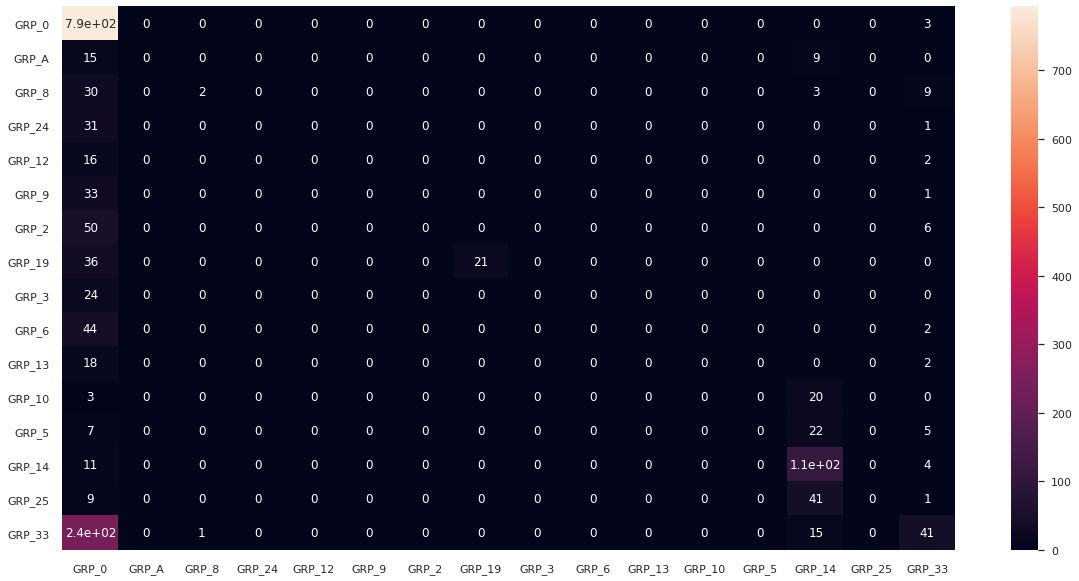

In [ ]:
# Multinomial NB with Validation dataset
run_classification(MultinomialNB(), X_train1, X_val, y_train1, y_val)

Prediction Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
--------------------------------------------------------------------------------
Training accuracy: 75.70%
Testing accuracy: 67.10%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.95      0.81       796
           1       0.58      0.46      0.51        24
           2       0.43      0.27      0.33        44
           3       0.67      0.25      0.36        32
           4       0.69      0.50      0.58        18
           5       0.24      0.18      0.20        34
           6       0.59      0.29      0.39        56
           7       0.87      0.79      0.83 

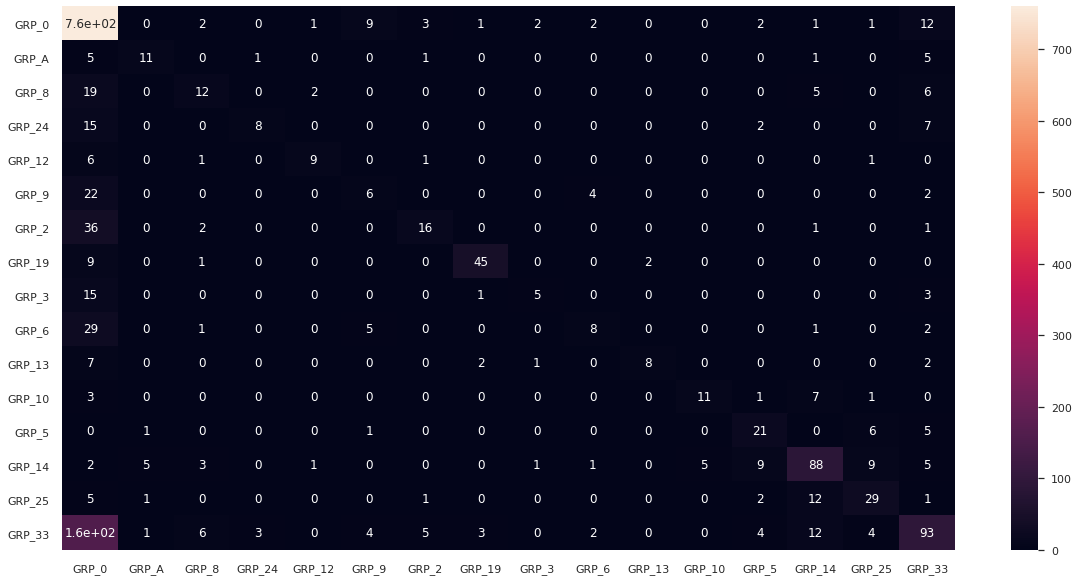

In [ ]:
# KNN with Validation dataset
run_classification(KNeighborsClassifier(), X_train1, X_val, y_train1, y_val)

Prediction Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
--------------------------------------------------------------------------------
Training accuracy: 96.71%
Testing accuracy: 72.86%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       796
           1       0.73      0.46      0.56        24
           2       0.67      0.50      0.57        44
           3       0.80      0.38      0.51        32
           4       0.62      0.44      0.52        18
           5       0.38      0.26      0.31        34
           6       0.70      0.38      0.49        56
 

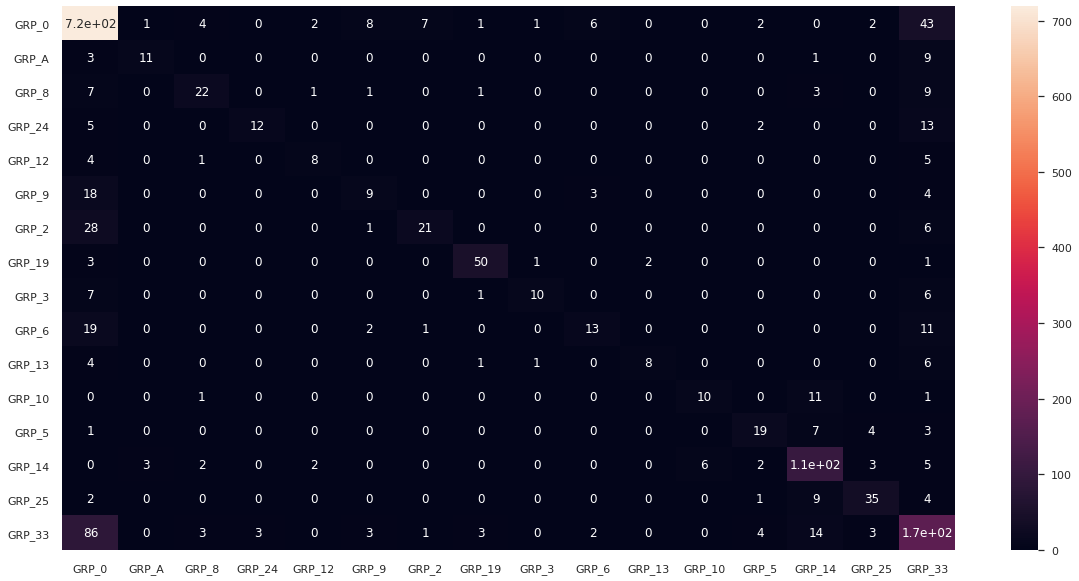

In [ ]:
# SVM with Linear kernel with validation dataset
run_classification(LinearSVC(), X_train1, X_val, y_train1, y_val)

Prediction Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
--------------------------------------------------------------------------------
Training accuracy: 99.80%
Testing accuracy: 58.14%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       796
           1       0.45      0.42      0.43        24
           2       0.31      0.36      0.34        44
           3       0

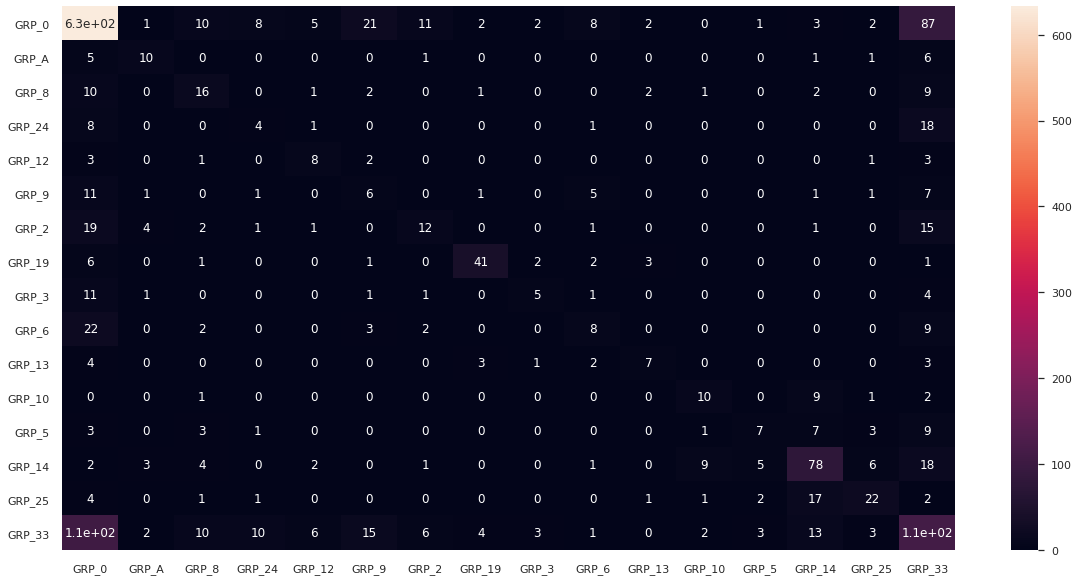

In [ ]:
# Decision Tree with Validation dataset
run_classification(DecisionTreeClassifier(), X_train1, X_val, y_train1, y_val)

Prediction Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
--------------------------------------------------------------------------------
Training accuracy: 99.80%
Testing accuracy: 66.09%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.80       796
        

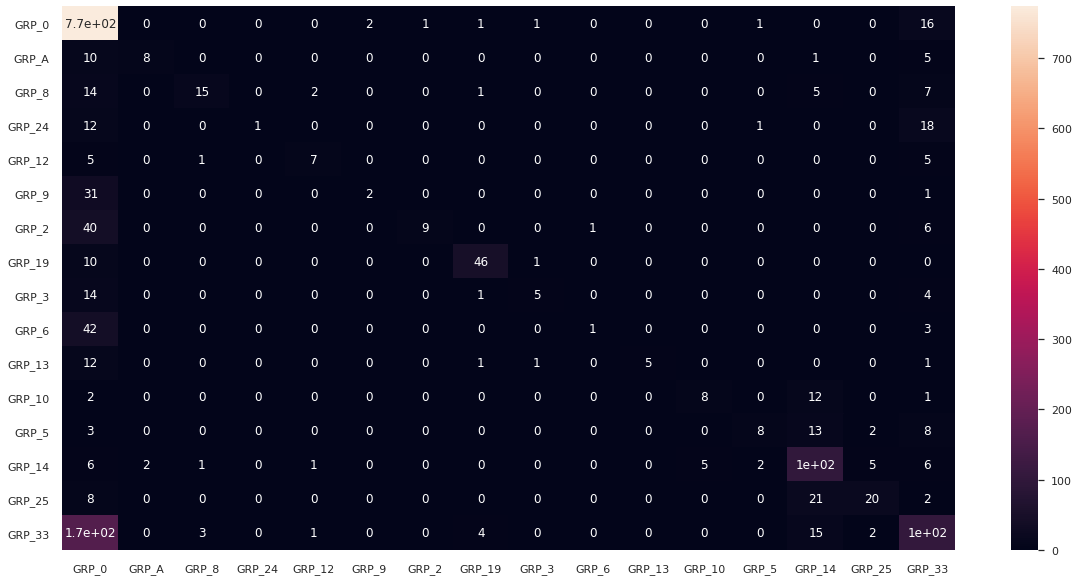

In [ ]:
# RandomForest Classifier with Validation dataset
run_classification(RandomForestClassifier(n_estimators=100), X_train1, X_val, y_train1, y_val)

### Bidirectional LSTM

In [ ]:
#Export the data frame to a .csv file
data2.to_csv (r'//content/drive/MyDrive/NLP_Project/temp.csv', index = False, header=True)

In [ ]:
import csv

vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8


articles = []
labels = []

with open("/content/drive/My Drive/NLP_Project/temp.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        article = row[0]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)


train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(17, activation='softmax')
])
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 17)                1105      
Total params: 395,409
Trainable params: 395,409
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
53/53 [==============================] - 33s 551ms/step - loss: 2.0522 - accuracy: 0.4720 - val_loss: 1.6612 - val_accuracy: 0.5160
Epoch 2/10
53/53 [==============================] - 25s 480ms/step - loss: 1.4160 - accuracy: 0.5847 - val_loss: 1.4261 - val_accuracy: 0.5624
Epoch 3/10
53/53 [==============================] - 25s 478ms/step - loss: 1.2270 - accuracy: 0.6452 - val_loss: 1.3605 - val_accuracy: 0.5814
Epoch 4/10
53/53 [==============================] - 25s 481ms/step - loss: 1.0810 - accuracy: 0.6761 - val_loss: 1.3344 - val_accuracy: 0.5825
Epoch 5/10
53/53 [==============================] - 25s 479ms/step - loss: 0.9399 - accuracy: 0.7096 - val_loss: 1.3256 - val_accuracy: 0.6051
Epoch 6/10
53/53 [==============================] - 25s 477ms/step - loss: 0.7991 - accuracy: 0.7552 - val_loss: 1.3565 - val_accuracy: 0.6033
Epoch 7/10
53/53 [==============================] - 25s 478ms/step - loss: 0.6859 - accuracy: 0.7892 - val_loss: 1.4036 - val_accuracy: 0.6099

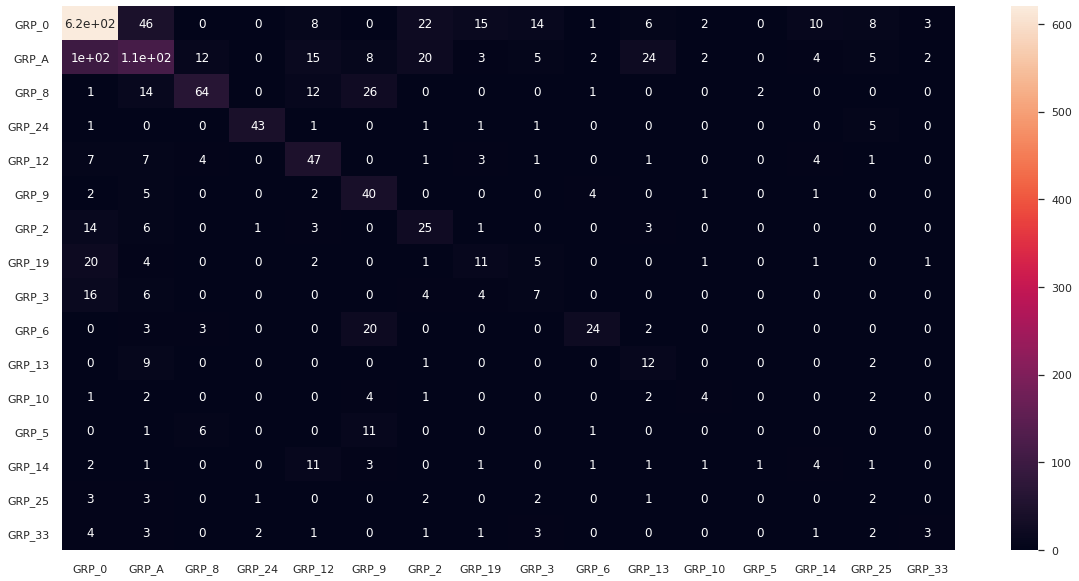

In [ ]:
run_classification(model, train_padded, validation_padded, training_label_seq, validation_label_seq,arch_name=None,pipelineRequired=False, isDeepModel=True)

## Dealing with Imbalanced dataset - Approach 2 - Resampling technique (Upsampling)

In [ ]:
data3.head()

Description Assignment group  Target
0  login issue verify user detail employee and ma...            GRP_0       0
1  outlook hello team meeting skype meeting etc b...            GRP_0       0
2  can not log in to vpn hi can not log on to vpn...            GRP_0       0
3  unable to access hr_tool page unable to access...            GRP_0       0
4                          skype error   skype error            GRP_0       0

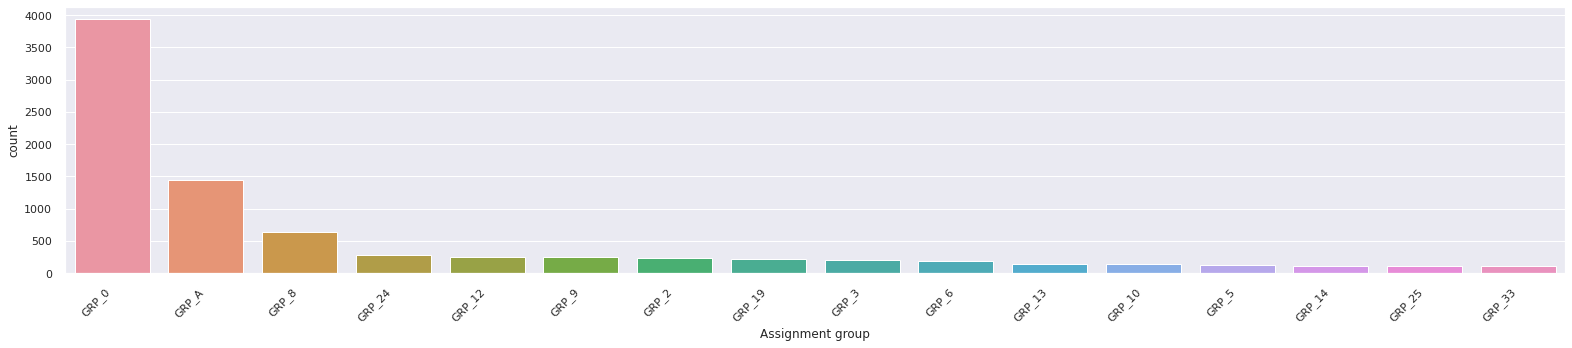

In [ ]:
target_count = data3['Target'].value_counts().sort_values(ascending=False).index
target_count

descending_order = data3['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=data2, order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

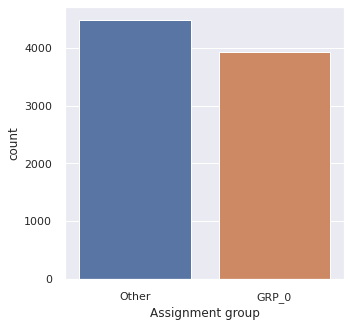

In [ ]:
# Create the Dataset for classifying GRP_0
GRP0 = data3.copy()
GRP0['Assignment group']= GRP0['Assignment group'].apply(lambda x : 'Other' if x != 'GRP_0'  else x)

descending_order = GRP0['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=GRP0, order=descending_order)

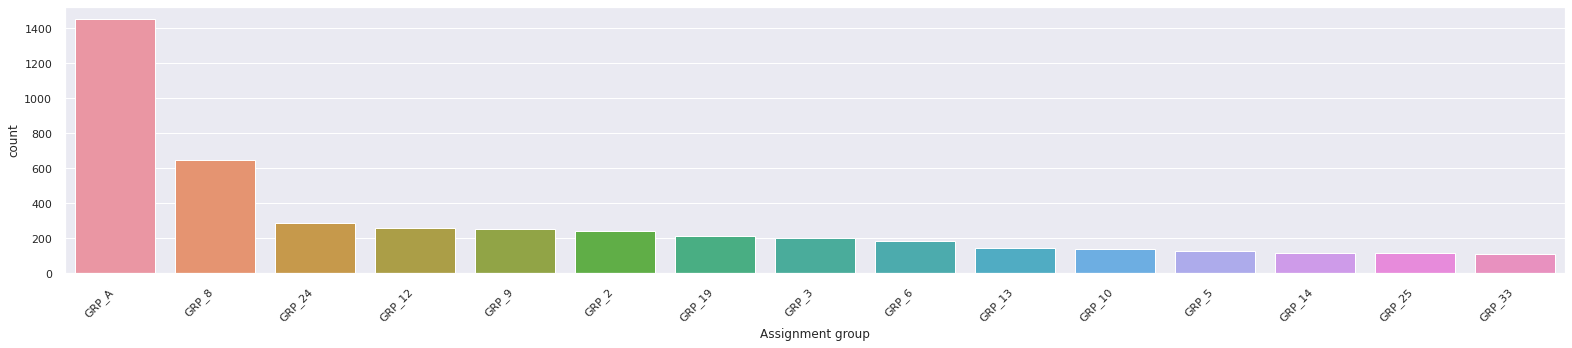

In [ ]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
Others = data3[data3['Assignment group'] != 'GRP_0']

descending_order = Others['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data = Others, order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
max = data3['Assignment group'].value_counts().max()
max

3934

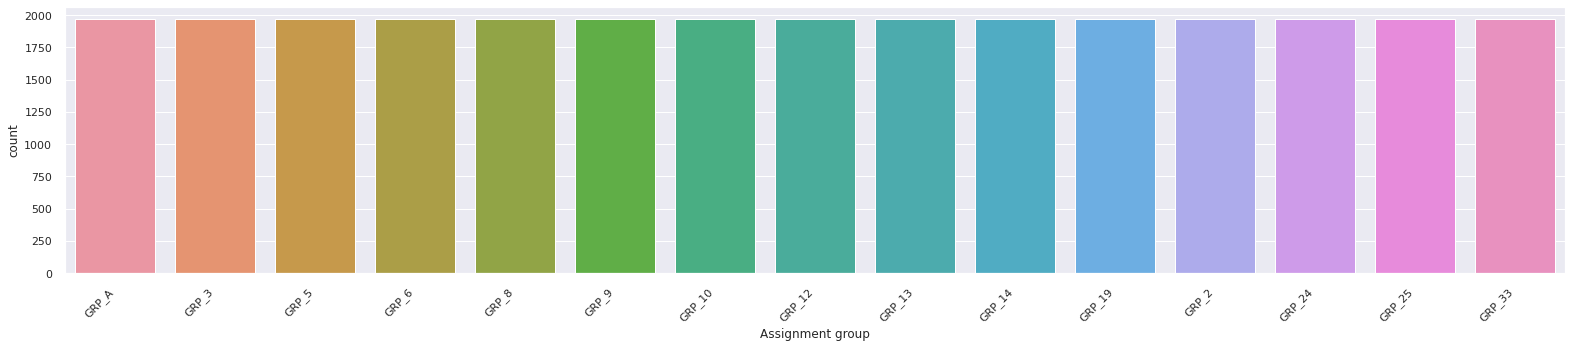

In [ ]:
# Treat the imbalnce in the 'other' dataset by resampling (upsampling)
from sklearn.utils import resample
Others_resampled = Others[0:0]
for grp in Others['Assignment group'].unique():
    data3 = Others[Others['Assignment group'] == grp]
    resampled = resample(data3, replace=True, n_samples=int(max/2), random_state=123)
    Others_resampled = Others_resampled.append(resampled)

otherGrpsResampled = pd.concat([GRP0,Others_resampled])
otherGrpsResampled.reset_index(inplace=True)

descending_order = Others_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=Others_resampled)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

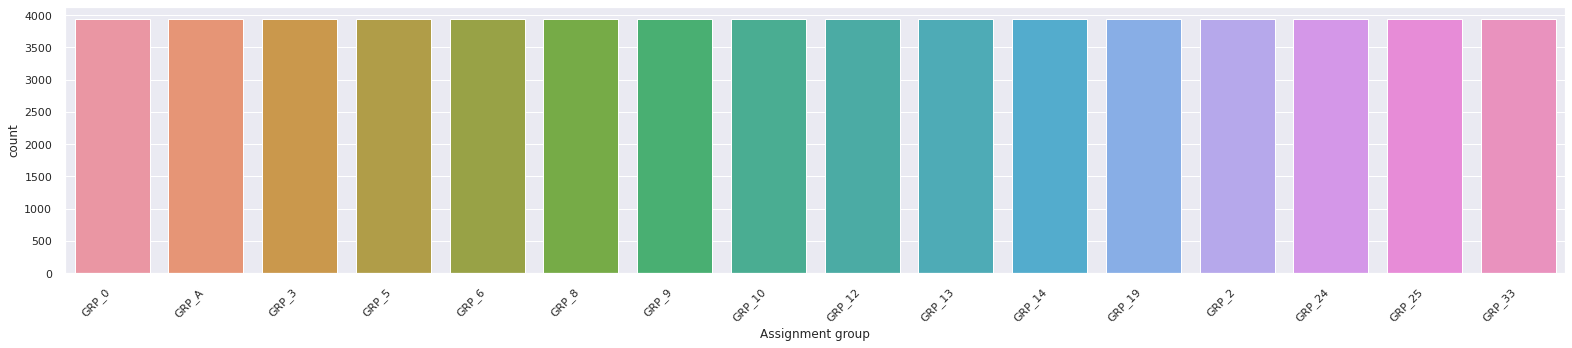

In [ ]:
# Treat the imbalance in the data dataset by resampling to 1984.This is for us to try creating a single model which use the whole dataset & verify the performance
data_resampled = data[0:0]
for grp in data['Assignment group'].unique():
    dataGrp = data[data['Assignment group'] == grp]
    resampled = resample(dataGrp, replace=True, n_samples=int(max), random_state=123)
    data_resampled = data_resampled.append(resampled)

descending_order = data_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=data_resampled)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Label Encoding 'Assignment group' target class

In [ ]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe = label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled = labelencoder(otherGrpsResampled['Assignment group'])
data_resampled['Assignment group'] , grp_mapping_all_resampled = labelencoder(data_resampled['Assignment group'])
data['Assignment group'],grp_mapping_all_raw = labelencoder(data['Assignment group'])

In [ ]:
#Export the data frame to a .csv file
data_resampled.to_csv (r'/content/drive/My Drive/NLP_Project/resampled_data.csv', index = False, header=True)

In [ ]:
# Split the data into Training, Validation and Test data sets
X_trainresampled, X_testresampled, y_trainresampled, y_testresampled = train_test_split(data_resampled.Description, 
                                                                                        data_resampled.Target, 
                                                                                        test_size=0.2, 
                                                                                        random_state=42)
X_trainresampled, X_val1, y_trainresampled, y_val1 = train_test_split(X_trainresampled, y_trainresampled, test_size=0.25, random_state=42)

print('\033[1mShape of the training set:\033[0m', X_trainresampled.shape, X_testresampled.shape)
print('\033[1mShape of the test set:\033[0m', X_testresampled.shape, y_testresampled.shape)
print('\033[1mShape of the validation set:\033[0m', X_val1.shape, y_val1.shape)

Shape of the training set: (37766,) (12589,)
Shape of the test set: (12589,) (12589,)
Shape of the validation set: (12589,) (12589,)


## Modeling with resampled data

### Multinomial Naive Bayes

Prediction Model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
--------------------------------------------------------------------------------
Training accuracy: 88.55%
Testing accuracy: 86.81%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70       781
           1       0.98      0.87      0.93       810
           2       0.90      0.87      0.88       776
           3       0.76      0.97      0.86       729
           4       0.89      0.96      0.92       778
           5       0.85      0.88      0.86       808
           6       0.83      0.96      0.89       758
           7       0.99      0.97      0.98       767
           8       0.91      0.99      0.95       763
           9       0.78      0.92      0.84       775
          

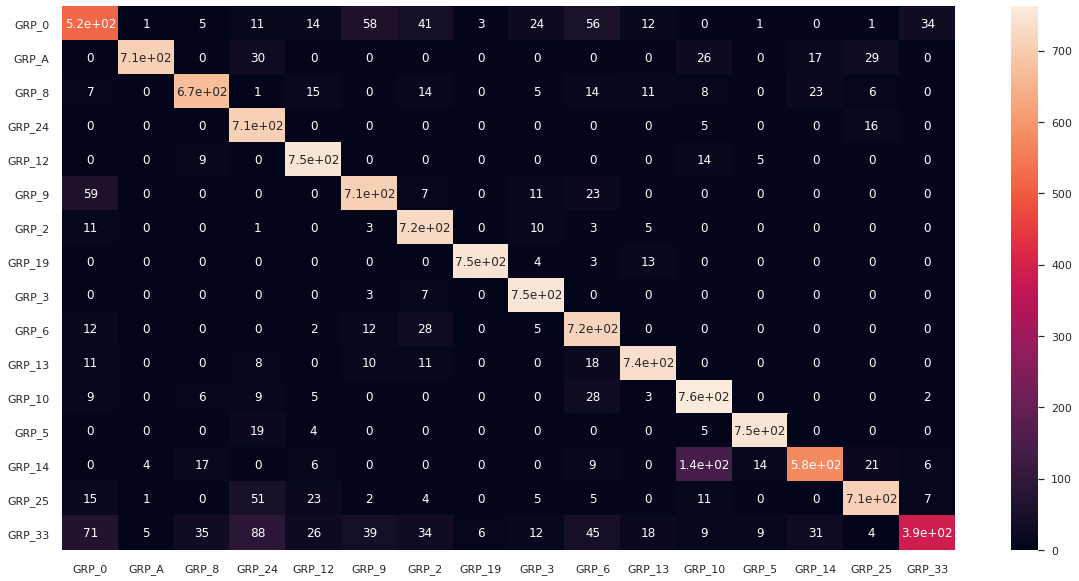

In [ ]:
run_classification(MultinomialNB(), X_trainresampled, X_val1, y_trainresampled, y_val1)

Prediction Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
--------------------------------------------------------------------------------
Training accuracy: 96.94%
Testing accuracy: 95.19%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80       781
           1       0.97      1.00      0.99       810
           2       0.94      1.00      0.97       776
           3       0.95      1.00      0.98       729
           4       0.97      1.00      0.98       778
           5       0.93      1.00      0.96       808
           6       0.93      0.99      0.96       758
           7       0.99      1.00      0.99 

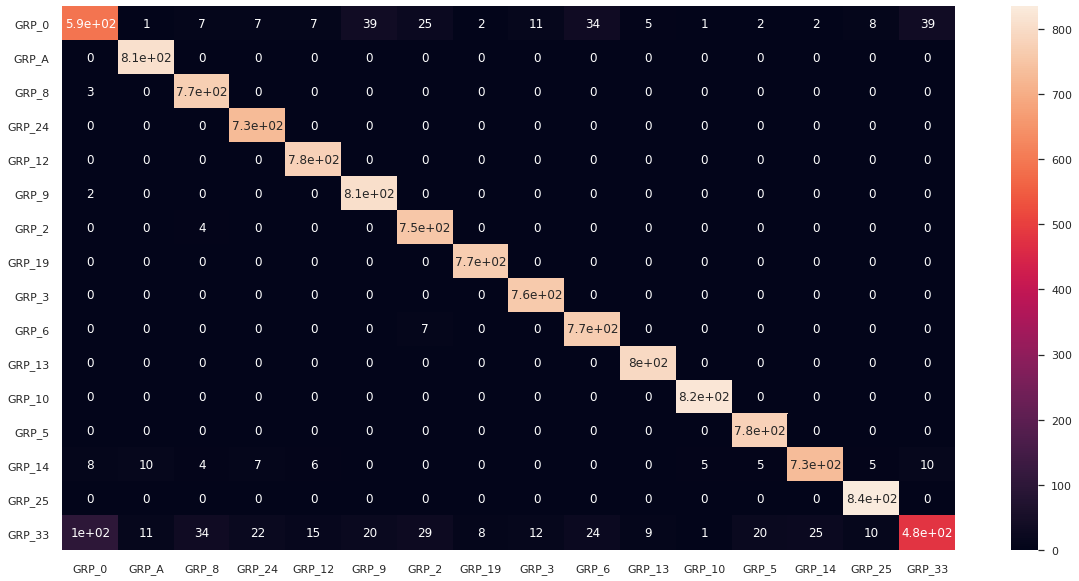

In [ ]:
run_classification(KNeighborsClassifier(), X_trainresampled, X_val1, y_trainresampled, y_val1)

### Support Vector Machine (SVM)

Prediction Model: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
--------------------------------------------------------------------------------
Training accuracy: 98.59%
Testing accuracy: 97.22%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       775
           1       0.97      1.00      0.98       791
           2       0.98      1.00      0.99       798
           3       0.98      1.00      0.99       802
           4       0.99      1.00      0.99       817
           5       0.96      0.99      0.97       784
           6       0.96      1.00      0.98       769
 

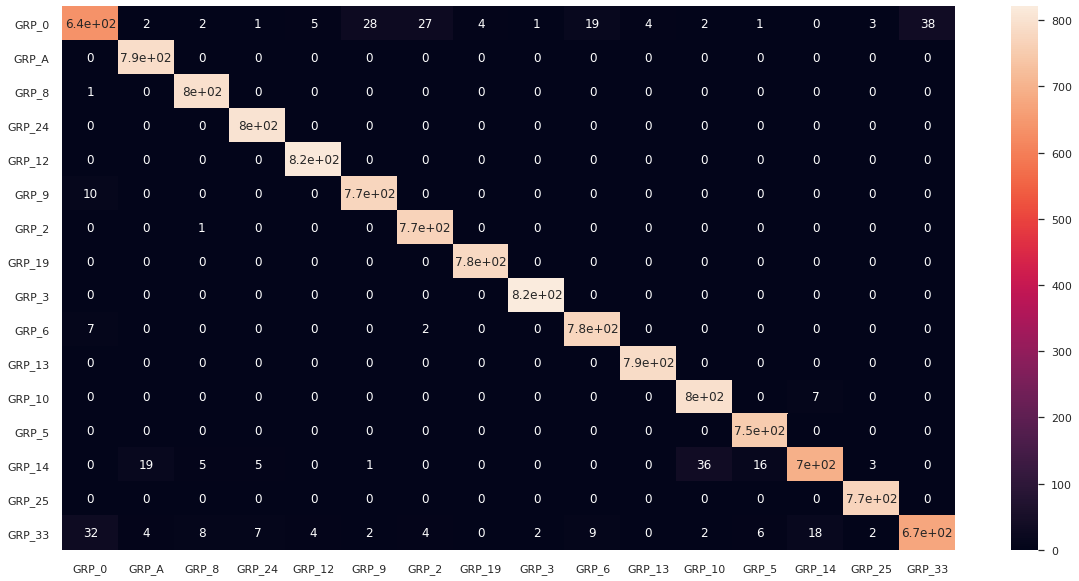

In [ ]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_trainresampled, X_testresampled, y_trainresampled, y_testresampled)

### Decision Trees

Prediction Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
--------------------------------------------------------------------------------
Training accuracy: 99.78%
Testing accuracy: 97.86%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       775
           1       0.99      1.00      1.00       791
           2       0.98      1.00      0.99       798
           3       0

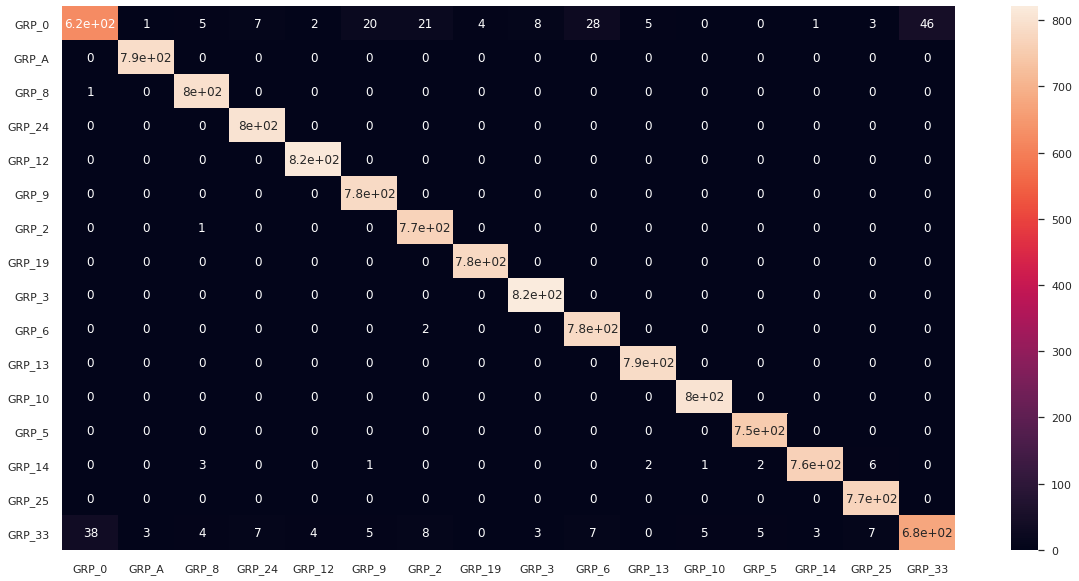

In [ ]:
run_classification(DecisionTreeClassifier(), X_trainresampled, X_testresampled, y_trainresampled, y_testresampled)

### Random Forest

Prediction Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
--------------------------------------------------------------------------------
Training accuracy: 99.78%
Testing accuracy: 98.84%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       775
        

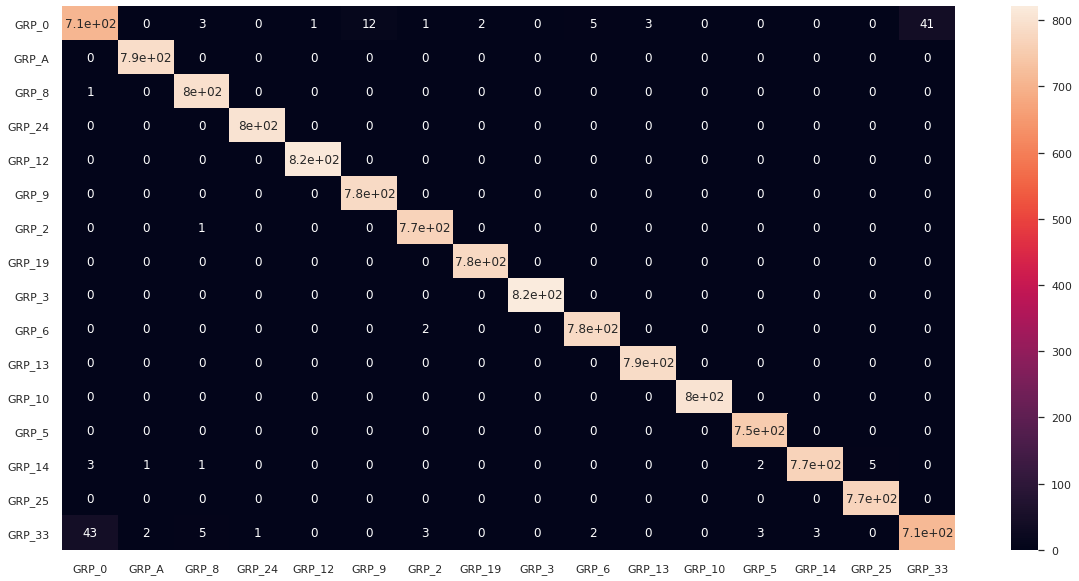

In [ ]:
run_classification(RandomForestClassifier(n_estimators=100), X_trainresampled, X_testresampled, y_trainresampled, y_testresampled)

### Bidirectional LSTM

In [ ]:
#Export the data frame to a .csv file
data_resampled.to_csv (r'/content/drive/My Drive/NLP_Project/resampled_data.csv', index = False, header=True)

In [ ]:
import csv

vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8


articles = []
labels = []

with open("/content/drive/My Drive/NLP_Project/temp.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        article = row[0]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)


train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(17, activation='softmax')
])
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 17)                1105      
Total params: 395,409
Trainable params: 395,409
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
53/53 [==============================] - 30s 514ms/step - loss: 2.0758 - accuracy: 0.4714 - val_loss: 1.6835 - val_accuracy: 0.5113
Epoch 2/10
53/53 [==============================] - 26s 497ms/step - loss: 1.4236 - accuracy: 0.5922 - val_loss: 1.4023 - val_accuracy: 0.5629
Epoch 3/10
53/53 [==============================] - 30s 562ms/step - loss: 1.2275 - accuracy: 0.6449 - val_loss: 1.3630 - val_accuracy: 0.5855
Epoch 4/10
53/53 [==============================] - 26s 492ms/step - loss: 1.0889 - accuracy: 0.6810 - val_loss: 1.3475 - val_accuracy: 0.5831
Epoch 5/10
53/53 [==============================] - 26s 492ms/step - loss: 0.9358 - accuracy: 0.7138 - val_loss: 1.3538 - val_accuracy: 0.5867
Epoch 6/10
53/53 [==============================] - 26s 488ms/step - loss: 0.8082 - accuracy: 0.7526 - val_loss: 1.3884 - val_accuracy: 0.6099
Epoch 7/10
53/53 [==============================] - 26s 488ms/step - loss: 0.6786 - accuracy: 0.7965 - val_loss: 1.3946 - val_accuracy: 0.5980

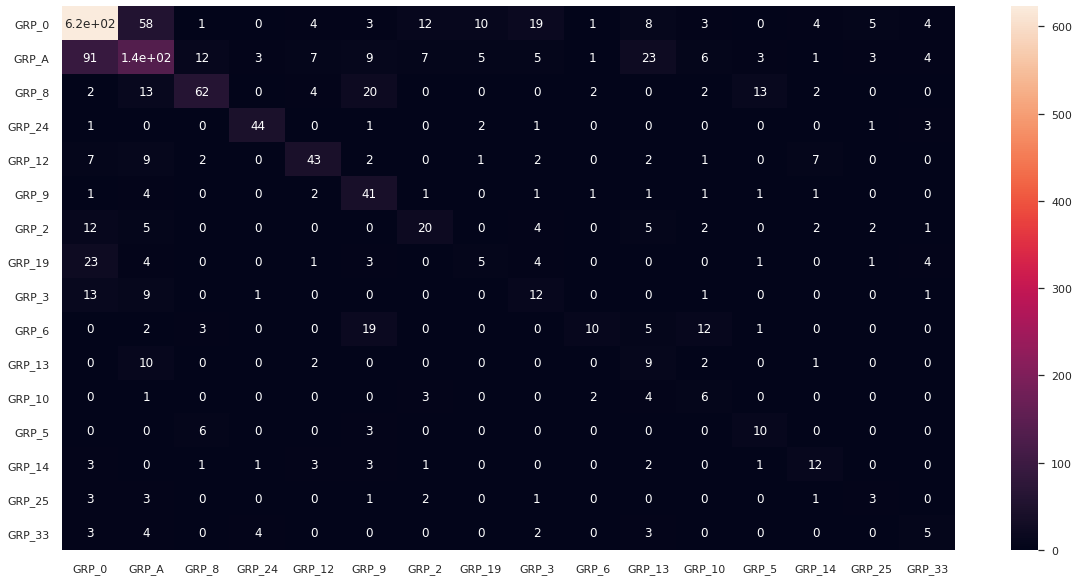

In [ ]:
run_classification(model, train_padded, validation_padded, training_label_seq, validation_label_seq,arch_name=None,pipelineRequired=False, isDeepModel=True)

## **Final Conclusion**
We first analysed the dataset provided to us, undestood the structure of the data provided - number of columns, field , datatypes etc.

> We first analysed the dataset provided to us, undestood the structure of the data provided - number of columns, field , datatypes etc.

> We did Exploratory Data Analysis to derive further insights from this data set and we found that
*   Data is very much imbalanced, there are around ~45% of the Groups with less than 20 tickets.
*   Few of the tickets are in foreign language like German
*   The data has lot of noise in it, for eg- few tickets related to account setup are spread across multiple assignment groups.

> We performed the data cleaning and preprocessing: 
*   Make text all lowercase so that the algorithm does not treat the same words in different cases as different
*   Removing Noise i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values
*   Removing extra spaces
*   Removed punctuations
*   Removed words containing numbers
*   Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words
*   Lemmatization
*   Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.

> We then trained various supervised machine learning models using the cleaned and preprocessed dataset.

> We trained the dataset using below models:
*   Multinomial NB
*   K Nearest Neighbors
*   Linear Support vector Machine
*   Decision Tree
*   Random Forest
*   Bidirectional LSTM
   
We were able to attain much greater accuracy after we upsampled the data of other groups during method 2. Snapshot of the same is attached for your reference.

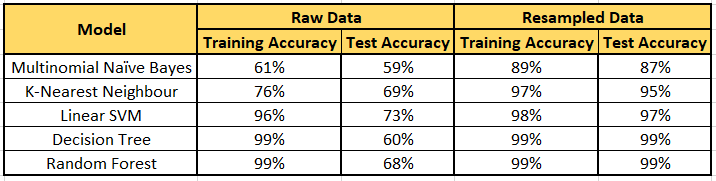

This shows that a properly cleaned and preprocessed data holds powers to propel even simpler models to race ahead of complex models and beat them in accuracy and other metric parameters.

# As we saw that the accuracy that we got after implementing models on upsampled dataset clearly indicates that the models are biased 

## So we will try to consider a different approach in handling imbalanced dataset, which we have clearly mentioned in the  interim report and mentioning the points here as well

### Future Approach

### 1.	We will try to reduce the number of classes from 16 to optimal number using K-means clustering ( Elbow Method )

### 2.	We will try to translate non English words into English.

### 3.	We will try to handle our imbalanced dataset using up sampling and down sampling.

### 4.	We will use SMOTE technique for handling imbalanced dataset

### 5.	We will implement 2 deep learning models as well for better inference.